In [1]:
library(IRdisplay)
display_html("<style>.container { width:100% !important; }</style>")

In [2]:
suppressPackageStartupMessages(library(data.table))
suppressPackageStartupMessages(library(purrr))
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(assertthat))
suppressPackageStartupMessages(library(optparse))
suppressPackageStartupMessages(library(scran))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(gridExtra))
suppressPackageStartupMessages(library(grid))

In [3]:
opts <- list()
opts$experiment <- "second_batch"
opts$inputdir <- paste0("/nfs/research1/marioni/Leah/scNMTseq/ModelSystems/10x_gastrulation_TetChimera_Data/original/",opts$experiment,"/")
opts$settings <- "/nfs/research1/marioni/Leah/scNMTseq/ModelSystems/10x_gastrulation_TetChimera/Leah_scripts/processing/settings.R"
#opts$output.seurat <- paste0("/nfs/research1/marioni/Leah/scNMTseq/ModelSystems/TettKOchimera/processed/",opts$experiment,"/seurat.rds")
#opts$output.metadata <- paste0("/nfs/research1/marioni/Leah/scNMTseq/ModelSystems/TettKOchimera/processed/",opts$experiment,"/sample_metadata.txt")
#opts$output.gene.metadata <- paste0("/nfs/research1/marioni/Leah/scNMTseq/ModelSystems/TettKOchimera/processed/",opts$experiment,"/gene_metadata.txt")
opts$subset.proteincoding <- NULL

In [4]:
source(opts$settings)

if ((!is.null(io$qc)) && (io$qc != TRUE)){
    stop("In the settings file, qc must be NULL or TRUE.n", call.=FALSE)
} else if ((!is.null(io$subset.proteincoding)) && (!is.string(io$subset.proteincoding))){
    stop("In the settings file, subset.proteincoding must be NULL or a path.n", call.=FALSE)
}else if ((!is.null(io$scaledata)) && (io$scaledata != TRUE)){
    stop("In the settings file, scaledatav must be NULL or TRUE.n", call.=FALSE)
}

In [5]:
##############################
## Load and merge data sets ##
##############################

message("Loading datasets")

mtx <- list()
cell.info <- list()
gene.info <- list()

toiter <- io$samples[[opts$experiment]]
for (i in toiter) {
    
  # Load cell metadata
  barcode.loc <- sprintf("%s%s_barcodes.tsv.gz",opts$inputdir,i,i)
  cell.info[[i]] <- read.delim(barcode.loc, header = FALSE, colClasses = "character", stringsAsFactors = FALSE, sep="\t")
  colnames(cell.info[[i]]) <- c("barcode")
  tmp <- strsplit(i,"_")[[1]]
  
  if (opts$experiment == "second_batch") {
  
    cell.info[[i]]$stage <- tmp[1]
    if (grepl("Rep", tmp[2], fixed=TRUE)) {
      cell.info[[i]]$Rep <- tmp[2]
    } else {
      cell.info[[i]]$Rep <- NA
    }
    if (grepl("WT", i, fixed=TRUE)) {
      cell.info[[i]]$class <- "WT"
      cell.info[[i]]$target <- NA
      cell.info[[i]]$modification <- NA
    } else if (grepl("TET", i, fixed=TRUE)){
      cell.info[[i]]$class <- paste("TET",tmp[which(tmp=="TET")+1],sep="_")
      cell.info[[i]]$target <- "TET"
      cell.info[[i]]$modification <- tmp[which(tmp=="TET")+1]
    } else if (grepl("DNMT3A", i, fixed=TRUE)){
      # NOTE: RENAMING TO DNMT3B BECAUSE IT WAS A MISNAMING WHEN HANDLING THE FILES
      cell.info[[i]]$class <- paste("DNMT3B",tmp[which(tmp=="DNMT3A")+1],sep="_")
      cell.info[[i]]$target <- "DNMT3B"
      cell.info[[i]]$modification <- tmp[which(tmp=="DNMT3A")+1]
    } else {
      stop("Didn't recognise sample name based on hard-coding")
    }
    cell.info[[i]]$lane <- tmp[4]
    
  } else if (opts$experiment == "third_batch") {
  
    print("third_batch")
    cell.info[[i]]$SIG <- tmp[1]
    cell.info[[i]]$stage <- tmp[2]
    cell.info[[i]]$embryo <- tmp[3]
    cell.info[[i]]$class <- tmp[4]
    cell.info[[i]]$target <- tmp[5]
    cell.info[[i]]$modification <- tmp[6]
    cell.info[[i]]$lane <- tmp[7]
    
  }
  cell.info[[i]]$batch <- i
  
  # Load gene metadata (note we could just load this once)
  gene.loc <- sprintf("%s%s_features.tsv.gz",opts$inputdir,i,i)
  gene.info[[i]] <- read.delim(gene.loc, header = FALSE, colClasses = "character", stringsAsFactors = FALSE, sep="\t")[,c(1,2)]
  colnames(gene.info[[i]]) <- c("ens_id","symbol")
  
  # Load matrix  
  matrix.loc <- sprintf("%s%s_matrix.mtx.gz",opts$inputdir,i,i)
  mtx[[i]] <- Matrix::readMM(matrix.loc)
  rownames(mtx[[i]]) <- gene.info[[i]]$symbol
  colnames(mtx[[i]]) <- cell.info[[i]]$barcode
}

# bind gene names and remove human alignments
gene.info <- do.call("rbind", gene.info)
rownames(gene.info) <- NULL
gene.info <- unique(gene.info)
gene.info <- gene.info[grepl('mm10', gene.info$symbol),]
gene.info$ens_id <- stringr::str_split_fixed(gene.info$ens_id,"___",2)[,2]
gene.info$symbol <- stringr::str_split_fixed(gene.info$symbol,"___",2)[,2]
rownames(gene.info) <- NULL

# Concatenate cell  metadata
cell.info <- do.call("rbind",cell.info)
cell.info$cell <- paste("cell",1:nrow(cell.info),sep="_")
rownames(cell.info) <- cell.info$cell

# Concatenate matrices
mtx <- do.call("cbind",mtx)
colnames(mtx) <- cell.info$cell
mtx <- mtx[grepl('mm10', rownames(mtx)),]
rownames(mtx) <- stringr::str_split_fixed(rownames(mtx),"___",2)[,2]

Loading datasets



In [6]:
################
## Processing ##
################

message("Processing datasets...")

# Optionally subset protein-coding genes
if (!is.null(opts$subset.proteincoding)){
    genes <- fread(opts$subset.proteincoding)[,ens_id]
    genes <- genes[genes %in% mouse.genes]
    mouse.genes <- mouse.genes[mouse.genes %in% genes]
    mtx <- mtx[mouse.genes,]
}

# Subset cell metadata
cell.info <- cell.info[colnames(mtx),]

Processing datasets...



In [7]:
message("QCing...")

srat <- CreateSeuratObject(mtx, meta.data = cell.info)

srat[["percent.mt"]] <- PercentageFeatureSet(srat, pattern = "mt-")
ribo.genes <- c(grep(pattern = "^Rpl", x = rownames(srat), value = TRUE),grep(pattern = "^Rps", x = rownames(srat), value = TRUE))
srat[["percent.ribo"]] <- PercentageFeatureSet(srat, features = ribo.genes)

mtx_sub_list <- list()
cell.info_sub_list <- list()
srat_sub_list <- list()
batches <- unique(cell.info$batch)
for (b in batches) {
    srat_sub_list[[b]] <- subset(srat, subset = batch == b)
    cell.info_sub_list[[b]] <- srat_sub_list[[b]]@meta.data
    mtx_sub_list[[b]] <- srat_sub_list[[b]]@assays$RNA@counts
}

QCing...

Warning message:
“Non-unique features (rownames) present in the input matrix, making unique”


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



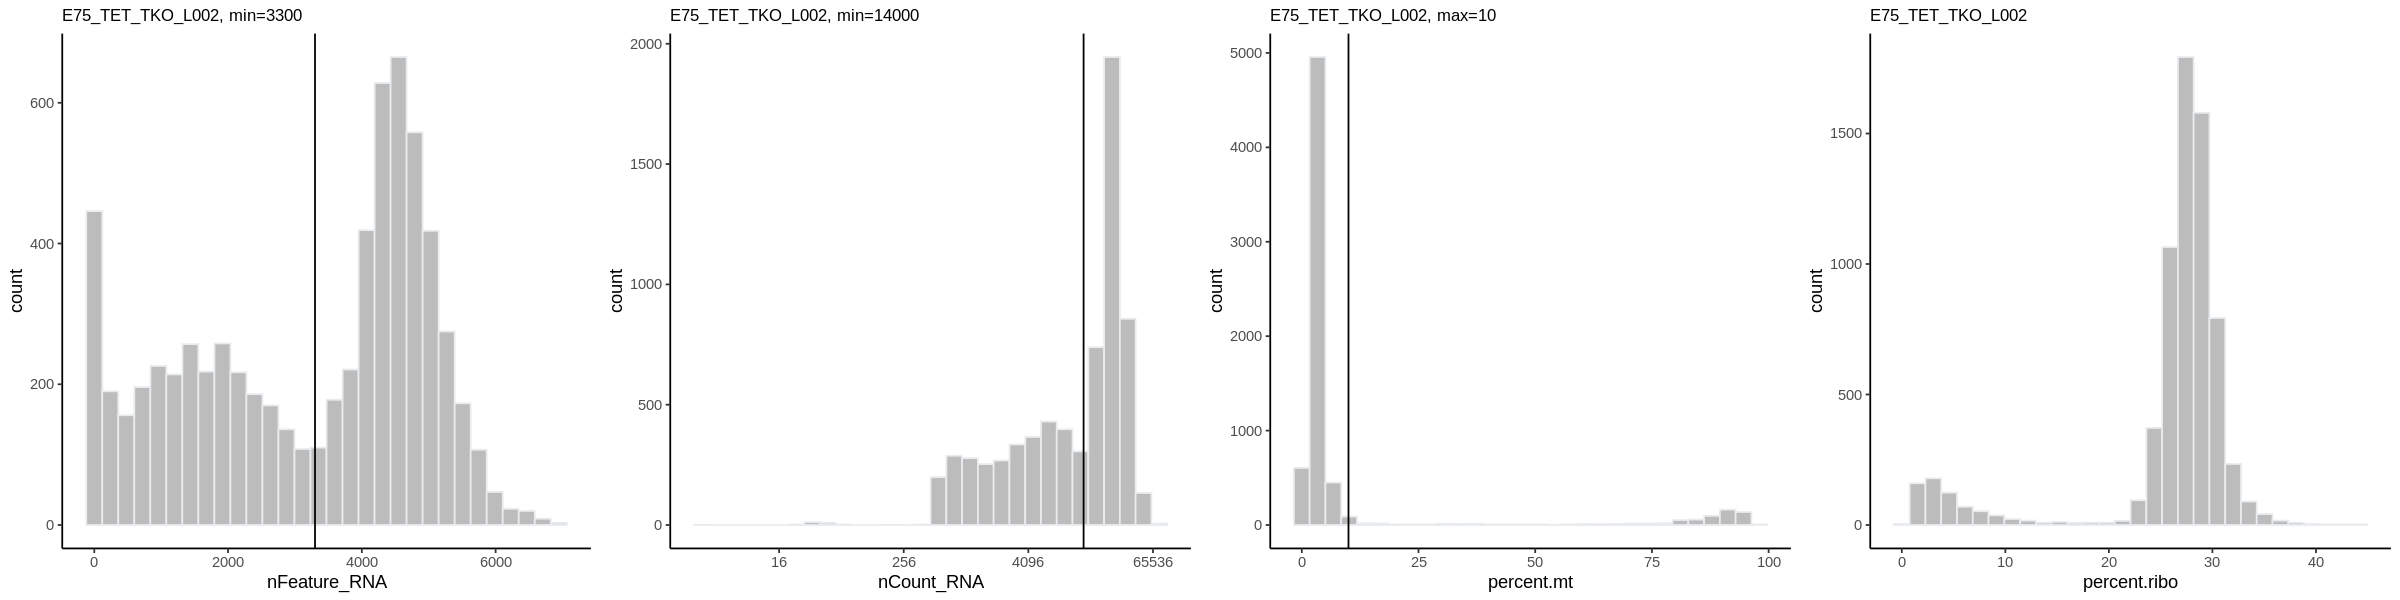

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



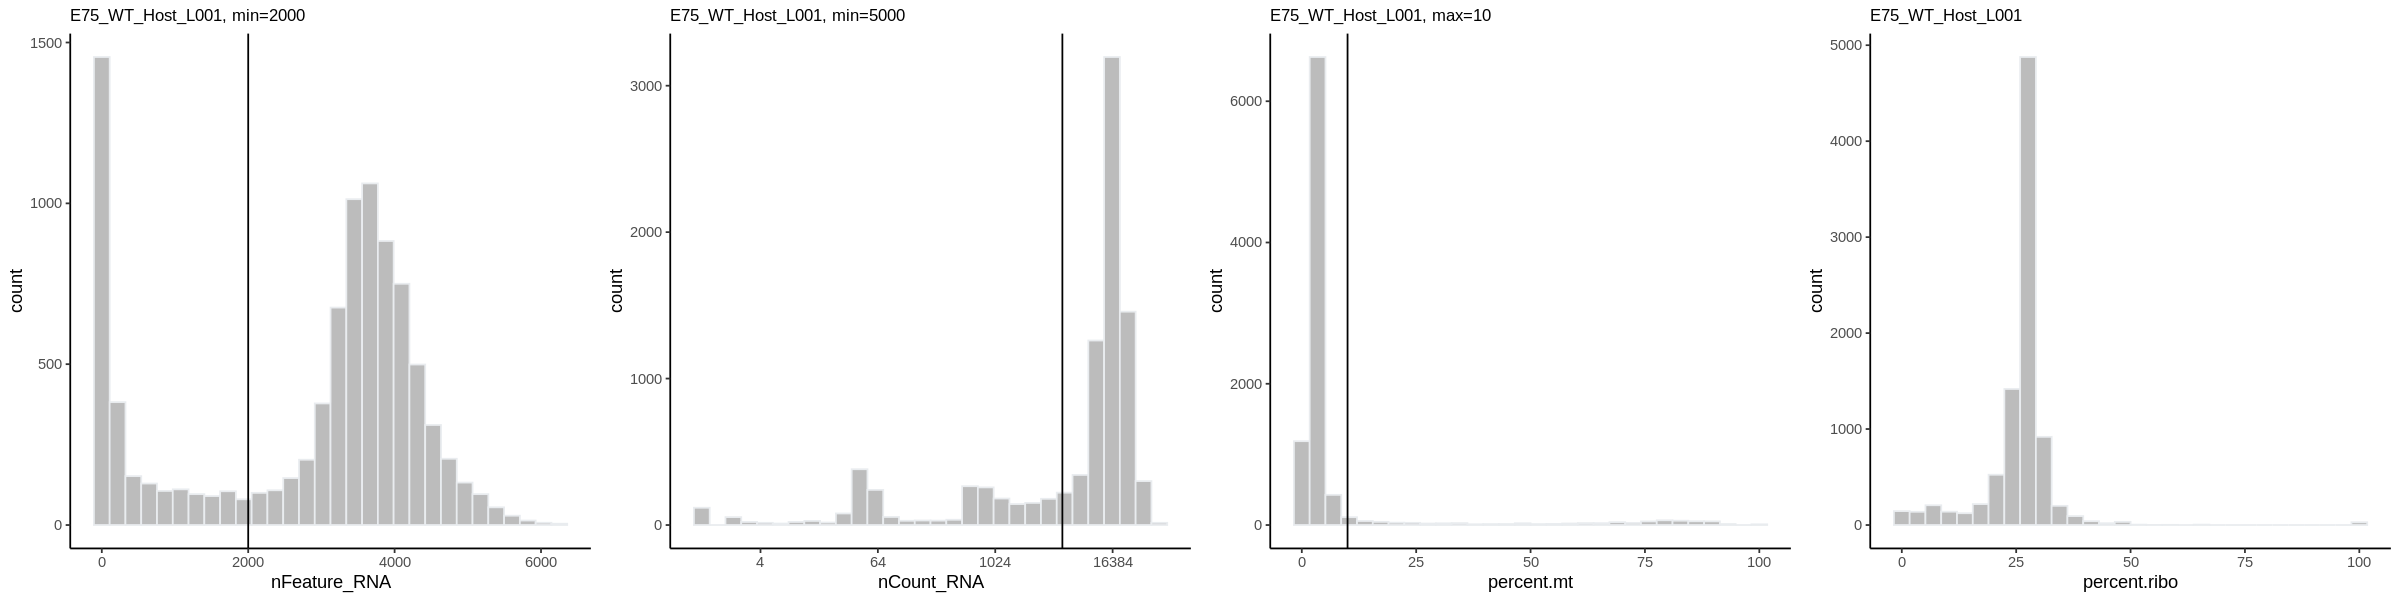

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



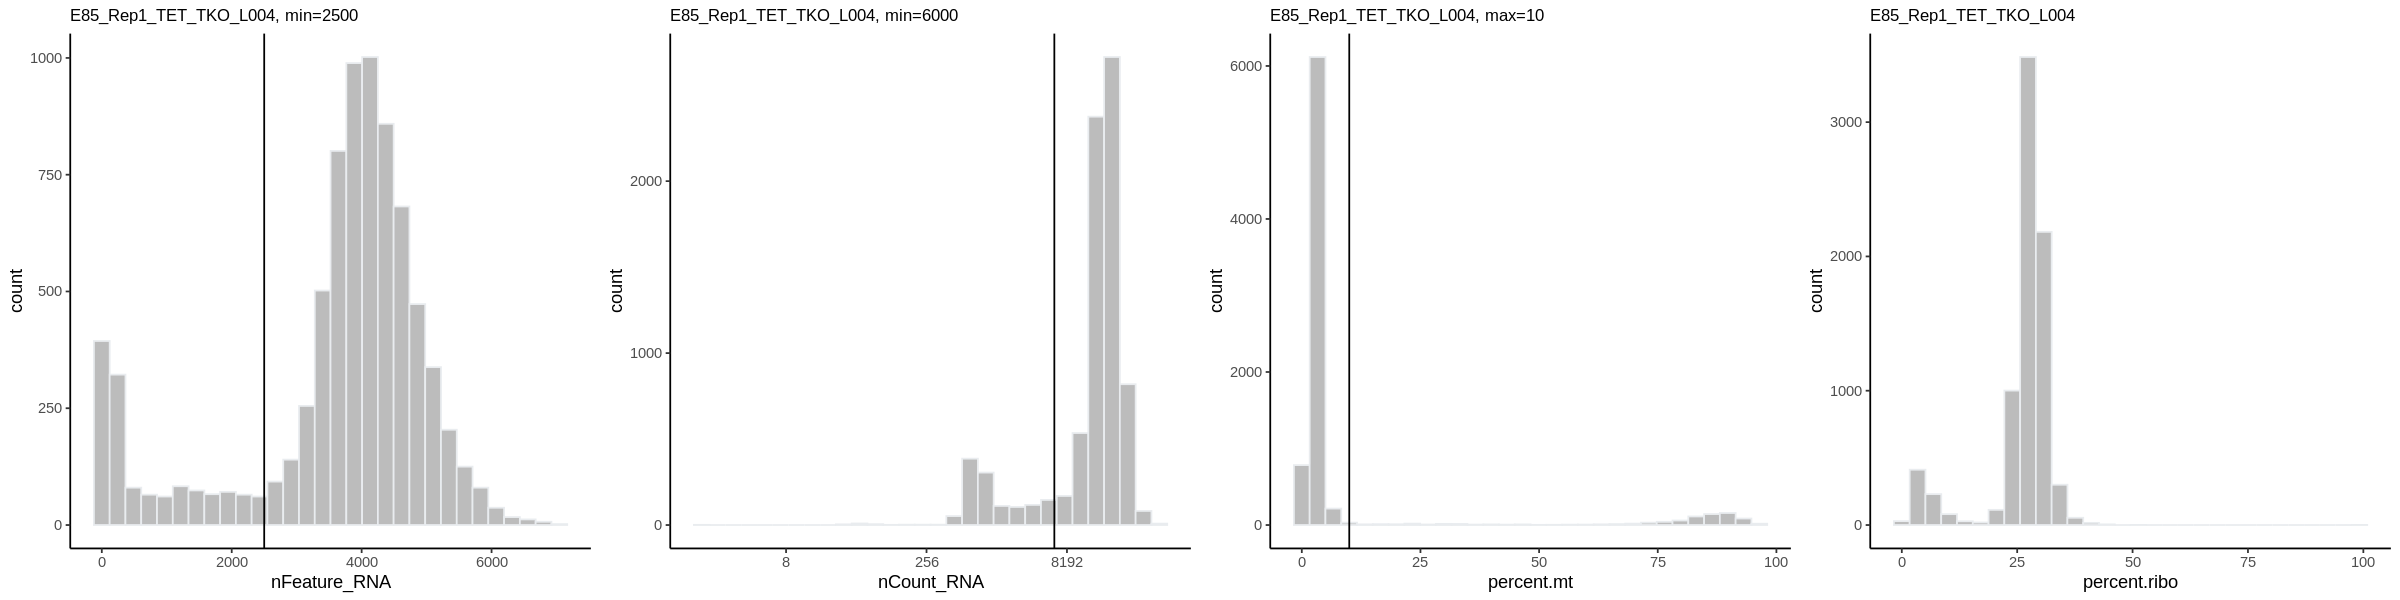

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



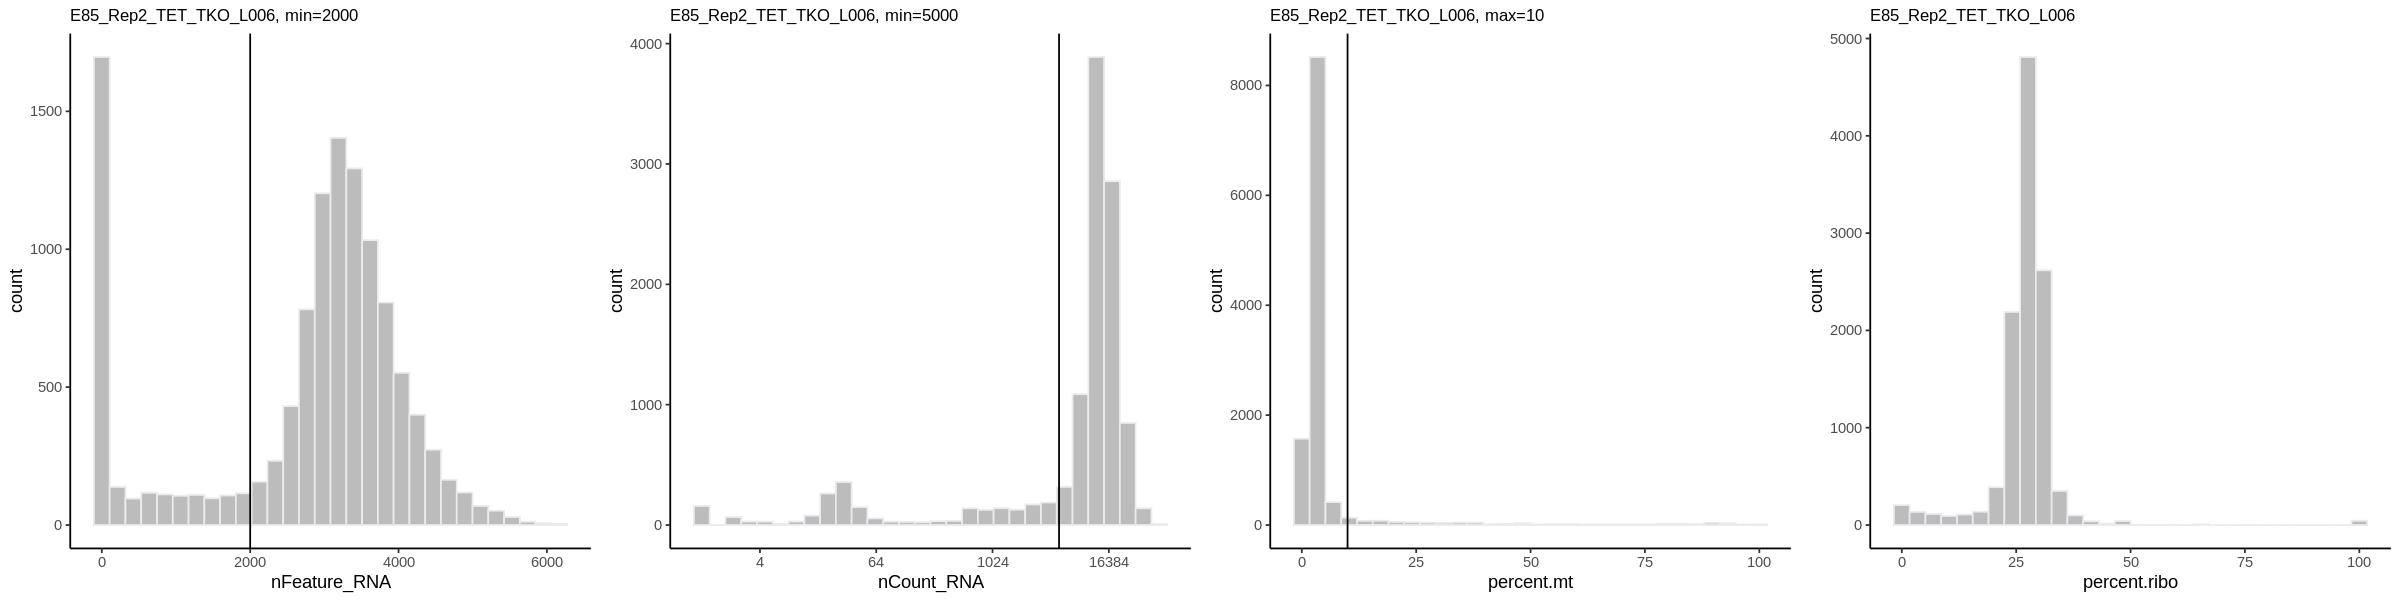

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



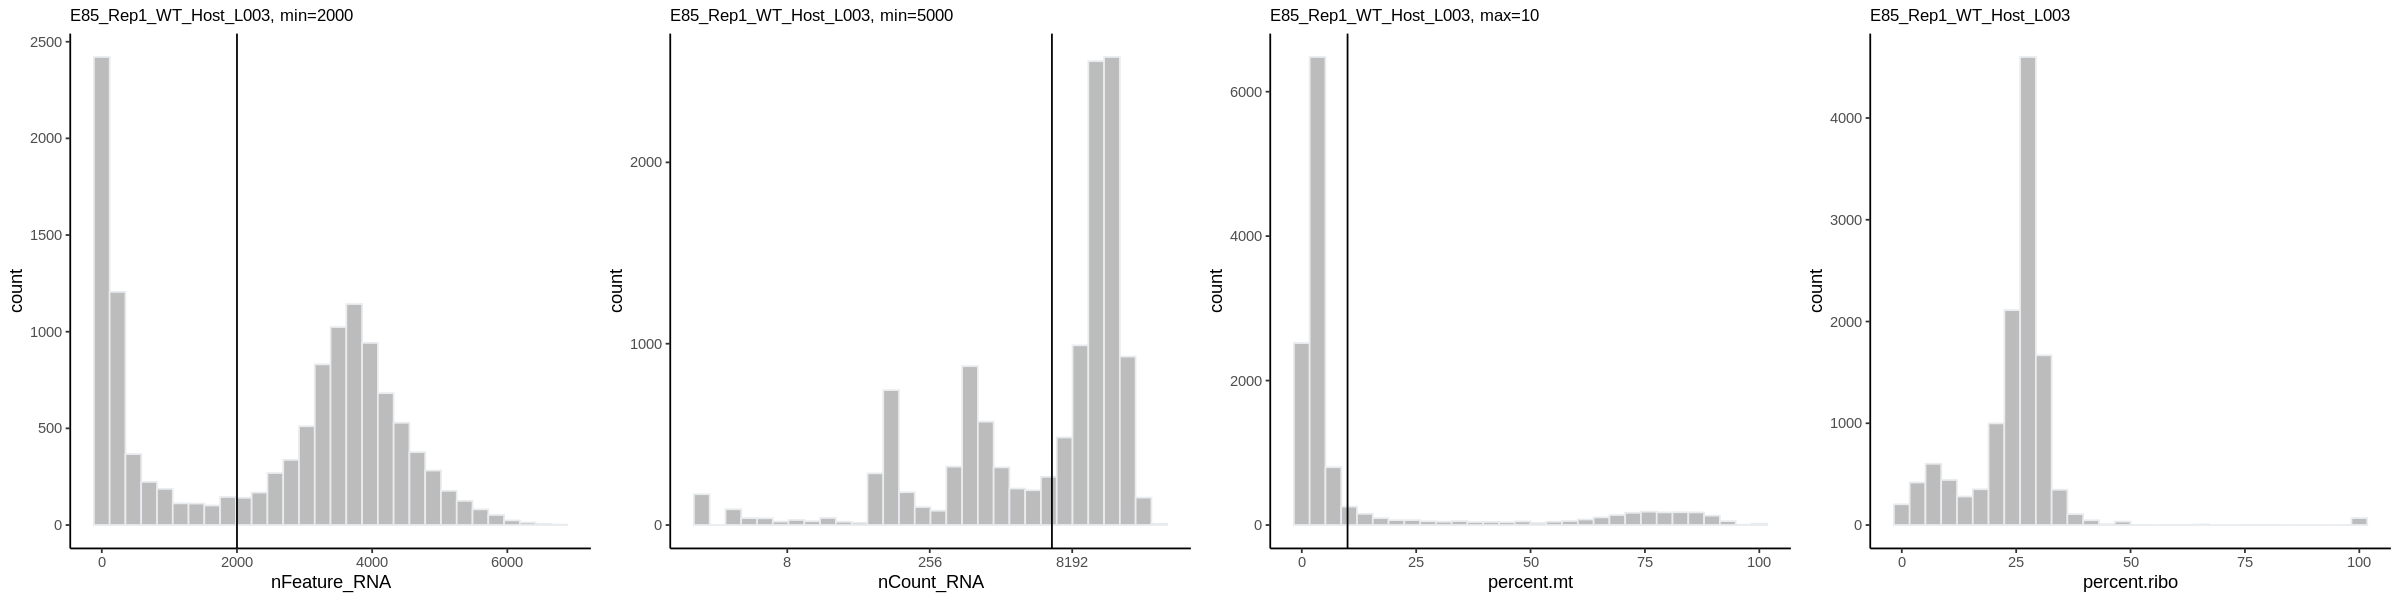

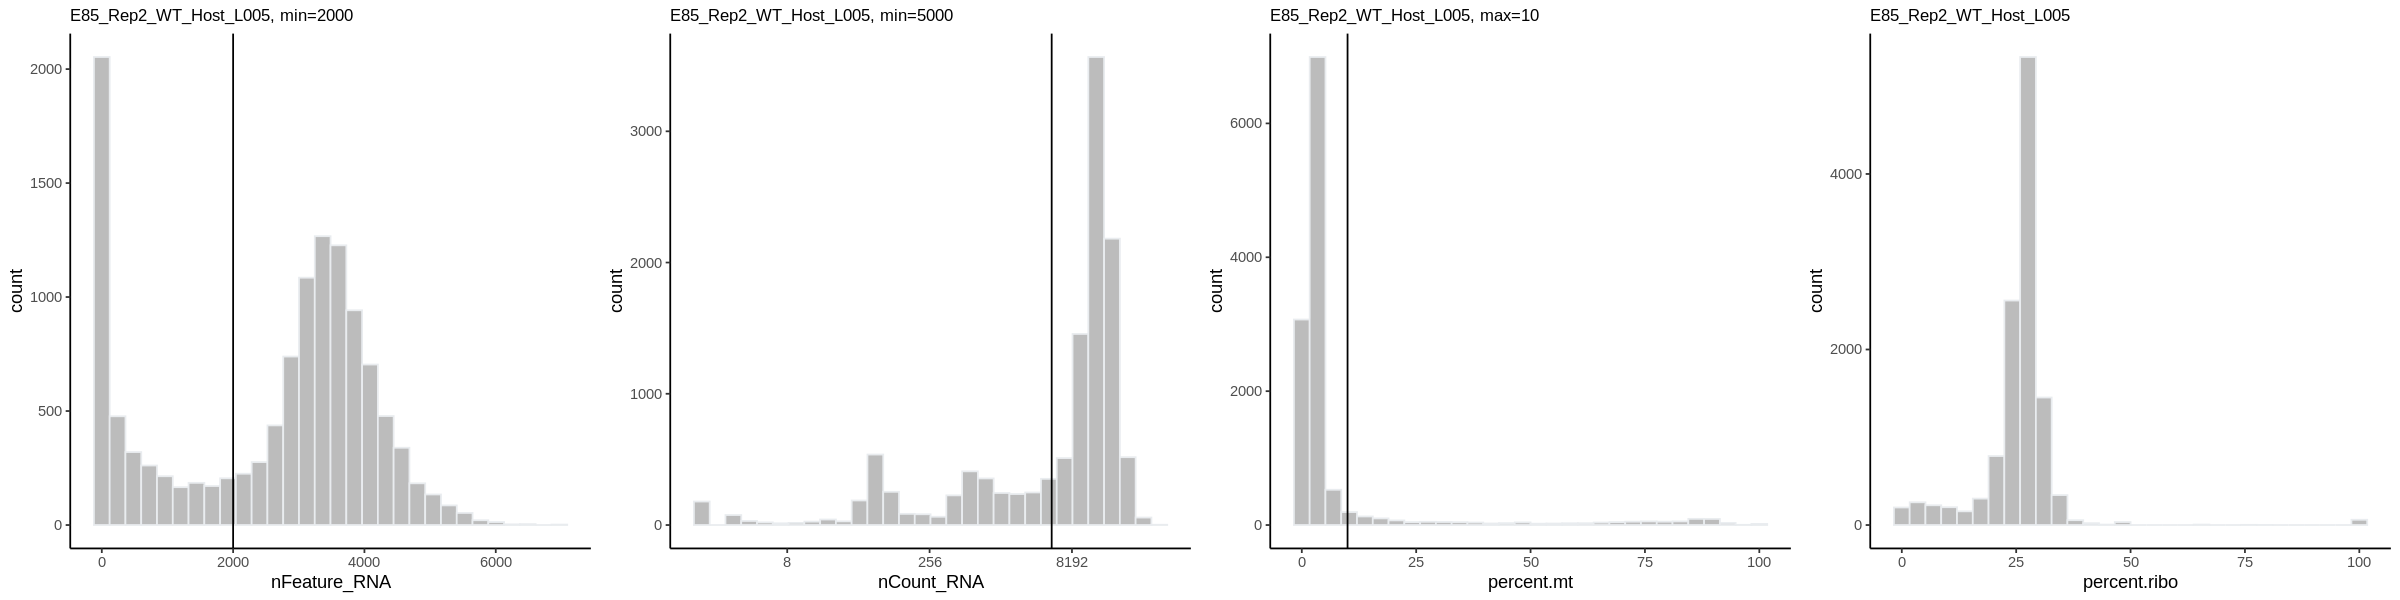

In [8]:
options(repr.plot.width=20, repr.plot.height=5)
options(warn=-1)

for (b in batches) {

    toplot <- data.frame(
      nFeature_RNA = srat_sub_list[[b]]$nFeature_RNA,
      nCount_RNA = srat_sub_list[[b]]$nCount_RNA,
      percent.mt = srat_sub_list[[b]]$percent.mt,
      percent.ribo = srat_sub_list[[b]]$percent.ribo
    )

    p1 <- (ggplot(toplot, aes(x=nFeature_RNA)) +
        geom_histogram( color="#e9ecef", alpha=0.4, position = 'identity') +
        scale_fill_manual(values=c("#69b3a2")) +
        labs(fill="") +
        geom_vline(xintercept=io$min_nFeature_RNA[[opts$experiment]][[b]]) +
        ggtitle(paste0(b, ", min=", io$min_nFeature_RNA[[opts$experiment]][[b]])) +
        theme_classic() +
        theme(plot.title = element_text(size = 10)))

    p2 <- (ggplot(toplot, aes(x=nCount_RNA)) +
        geom_histogram( color="#e9ecef", alpha=0.4, position = 'identity') +
        scale_fill_manual(values=c("#69b3a2")) +
        labs(fill="") +
        scale_x_continuous(trans='log2') +
        geom_vline(xintercept=io$min_nCount_RNA[[opts$experiment]][[b]]) +
        ggtitle(paste0(b, ", min=", io$min_nCount_RNA[[opts$experiment]][[b]])) +
        theme_classic() +
        theme(plot.title = element_text(size = 10)))

    p3 <- (ggplot(toplot, aes(x=percent.mt)) +
        geom_histogram( color="#e9ecef", alpha=0.4, position = 'identity') +
        scale_fill_manual(values=c("#69b3a2")) +
        labs(fill="") +
        geom_vline(xintercept=io$max_percent.mt[[opts$experiment]][[b]]) +
        ggtitle(paste0(b, ", max=", io$max_percent.mt[[opts$experiment]][[b]])) +
        theme_classic() +
        theme(plot.title = element_text(size = 10)))

    p4 <- (ggplot(toplot, aes(x=percent.ribo)) +
        geom_histogram( color="#e9ecef", alpha=0.4, position = 'identity') +
        scale_fill_manual(values=c("#69b3a2")) +
        labs(fill="") +
        ggtitle(b) +
        theme_classic() +
        theme(plot.title = element_text(size = 10)))

    grid.arrange(p1, p2, p3, p4, ncol=4)

}
options(warn=0)

In [9]:
srat_sub_list_pass_QC <- list()
for (b in batches) {
    md <- srat_sub_list[[b]]@meta.data
    md$pass_QC <- TRUE
    #md$pass_QC[md$nFeature_RNA < io$min_nFeature_RNA[[opts$experiment]][[b]]] <- FALSE
    md$pass_QC[md$nCount_RNA < io$min_nCount_RNA[[opts$experiment]][[b]]] <- FALSE
    md$pass_QC[md$percent.mt > io$max_percent.mt[[opts$experiment]][[b]]] <- FALSE
    srat_sub_list[[b]]@meta.data <- md
    sce_tmp <- as.SingleCellExperiment(subset(srat_sub_list[[b]], subset = pass_QC == TRUE))
    md$doublet_score <- NA
    tmp <- doubletCells(sce_tmp)
    md$doublet_score[md$pass_QC == TRUE] <- tmp
    print(sum(md$pass_QC))
    print(length(tmp))
    print("")
    srat_sub_list[[b]]@meta.data <- md
    srat_sub_list_pass_QC[[b]] <- subset(srat_sub_list[[b]], subset = pass_QC == TRUE)
}

[1] 3788
[1] 3788
[1] ""
[1] 6711
[1] 6711
[1] ""
[1] 6731
[1] 6731
[1] ""
[1] 9100
[1] 9100
[1] ""
[1] 7740
[1] 7740
[1] ""
[1] 8393
[1] 8393
[1] ""


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



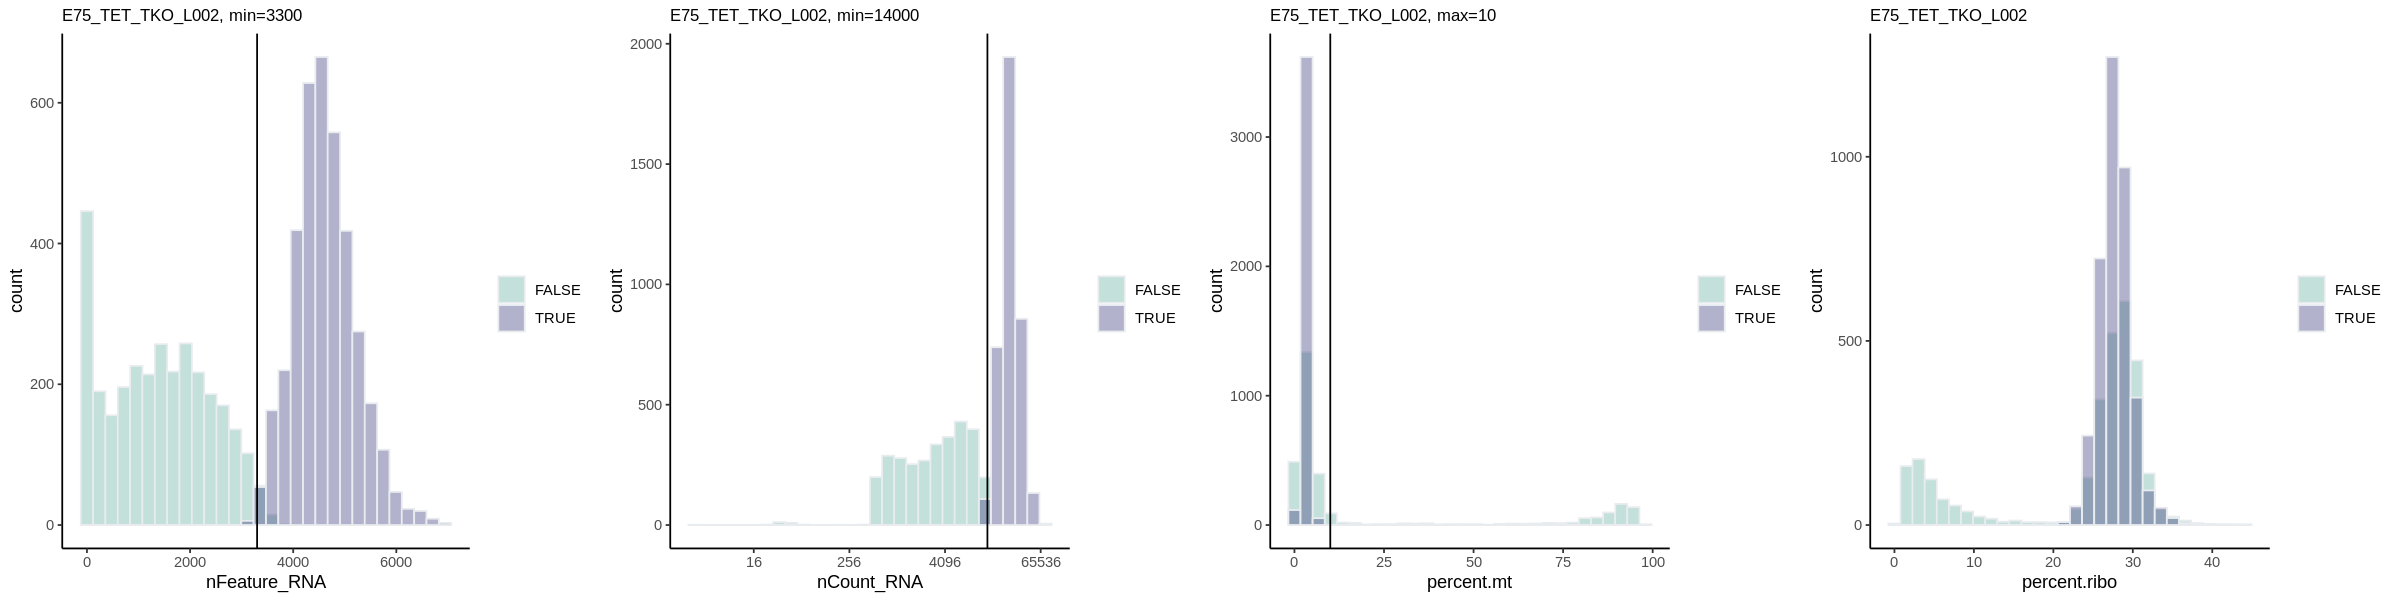

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



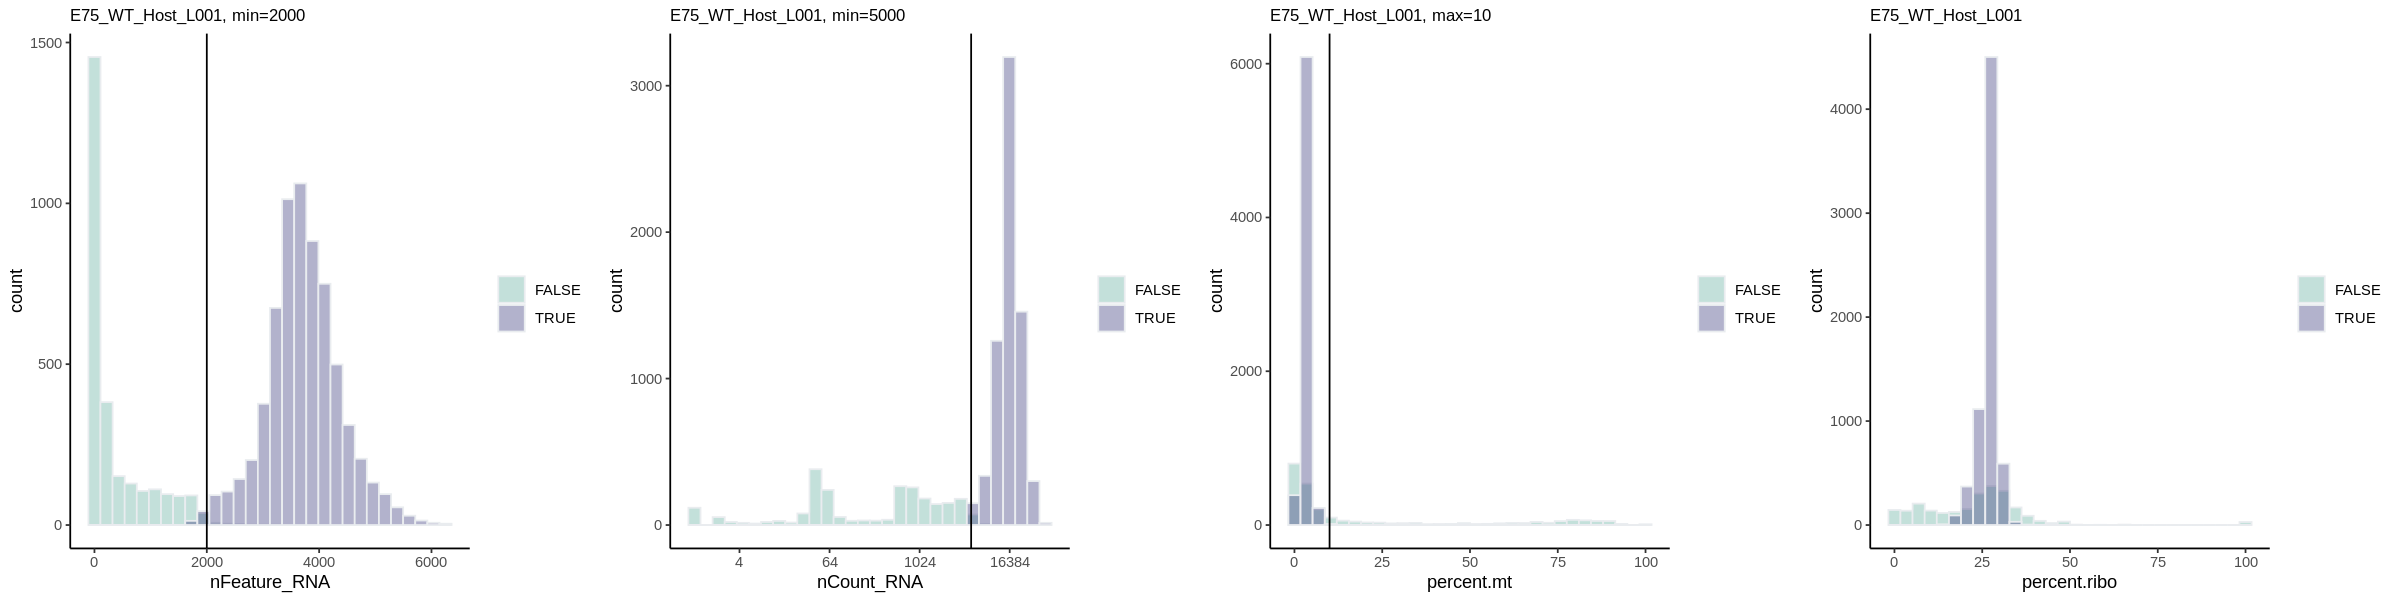

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



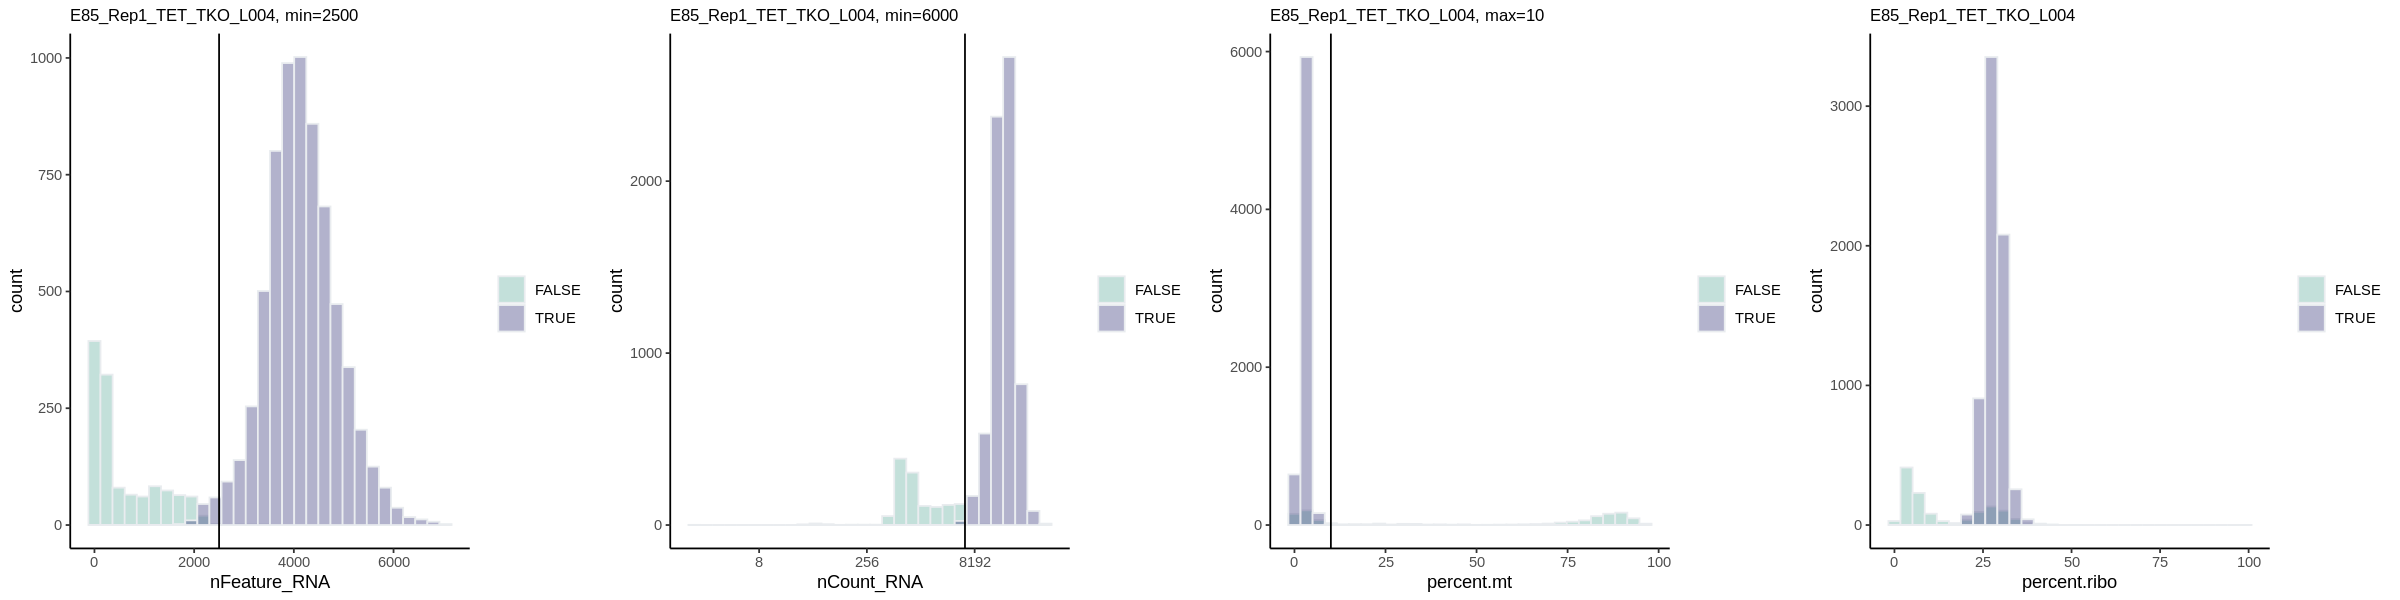

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



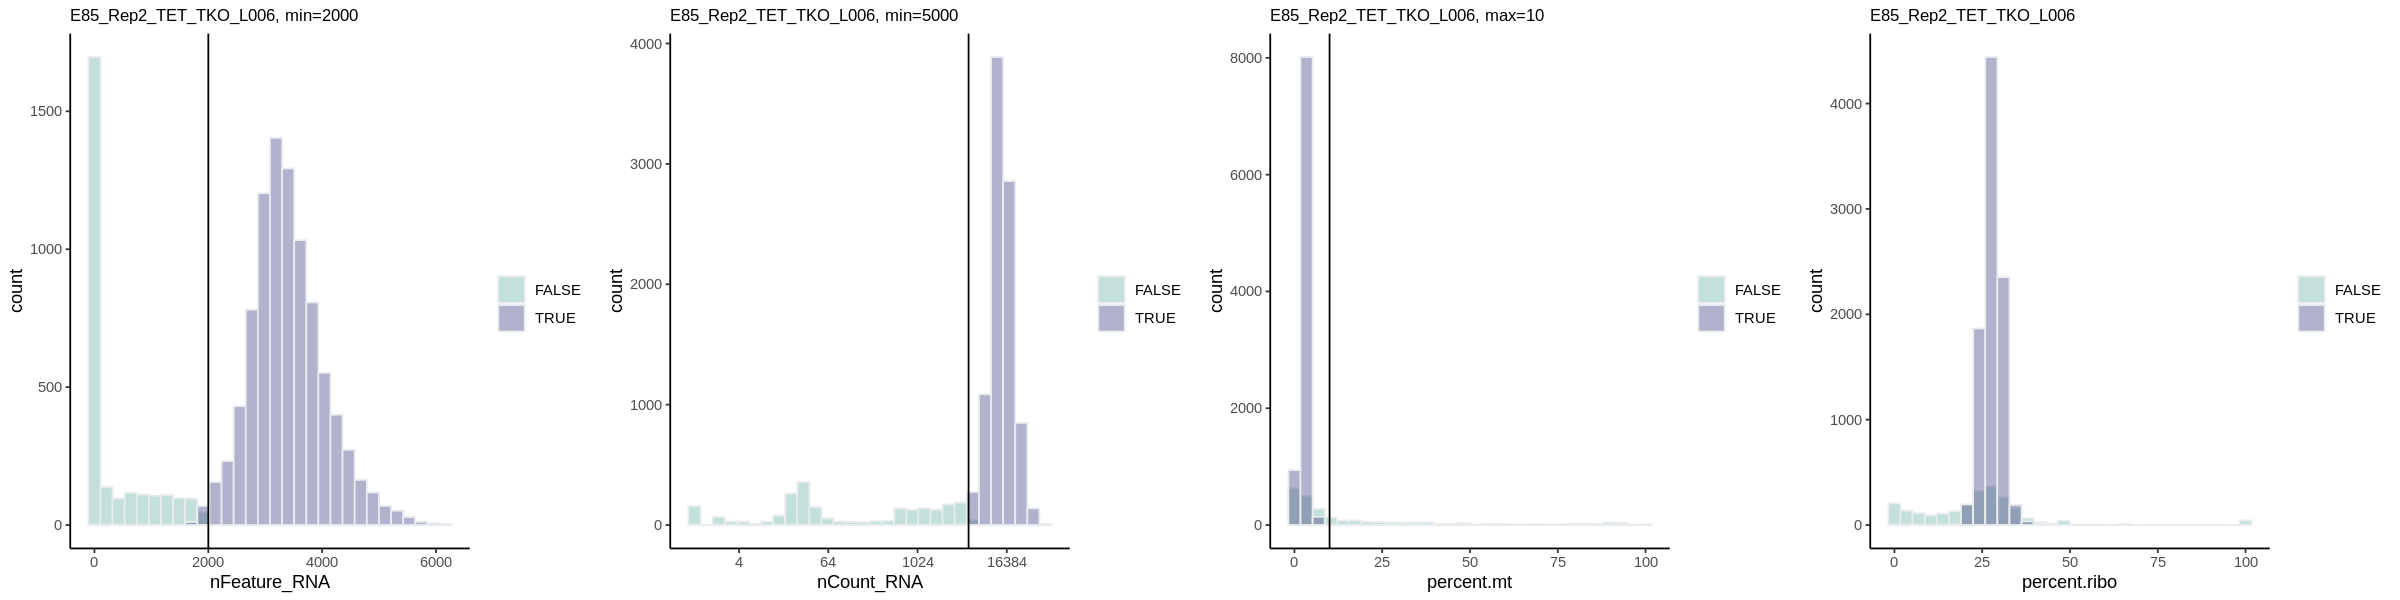

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



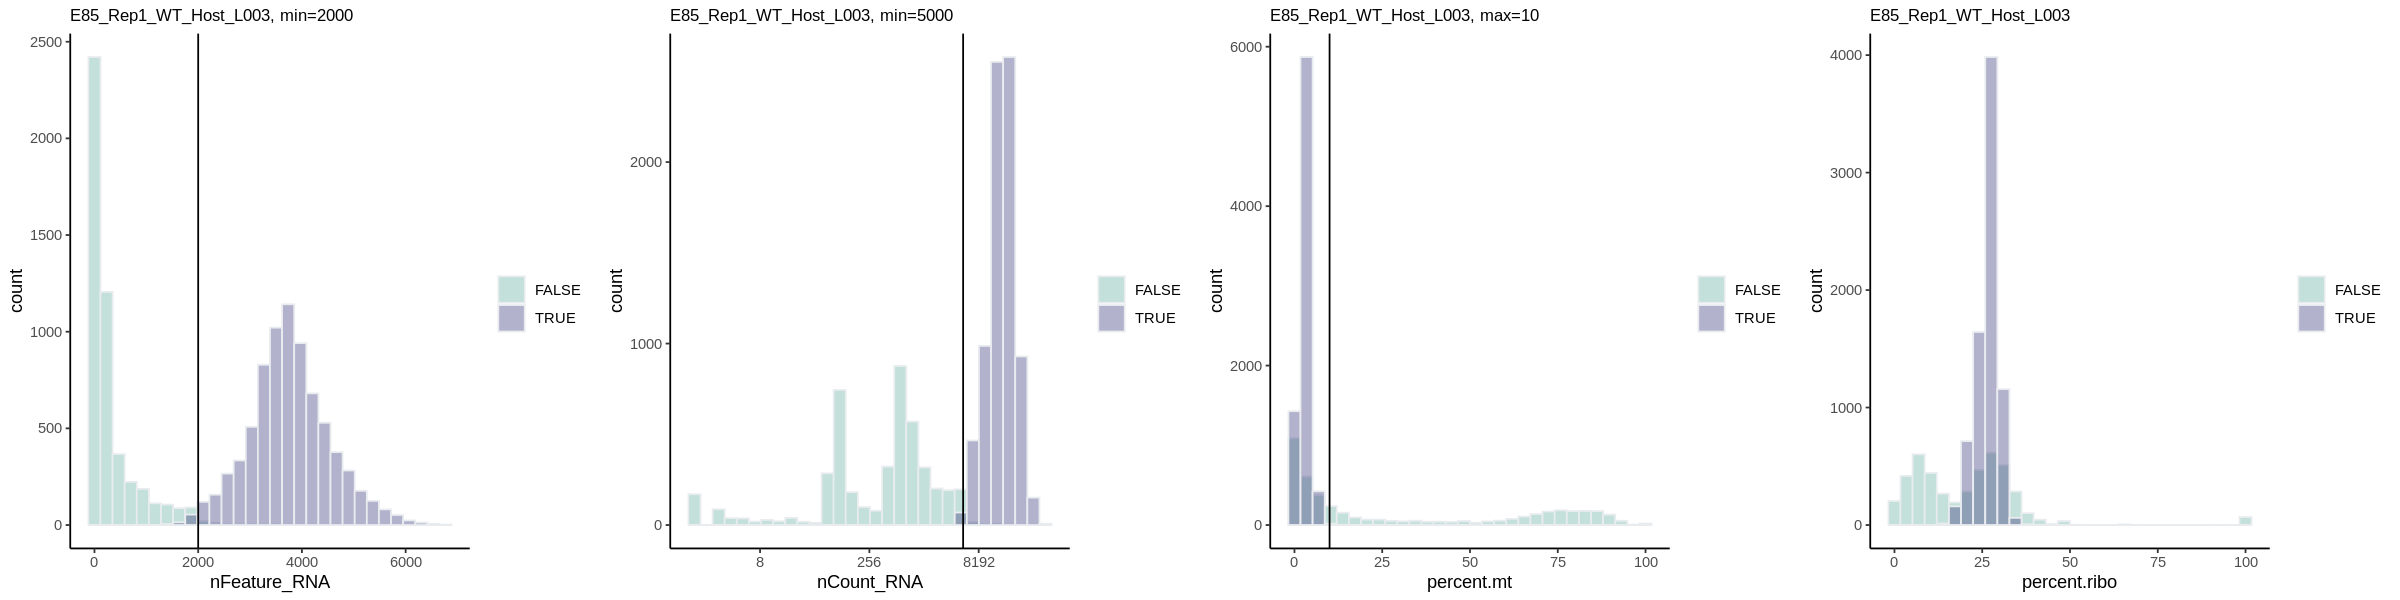

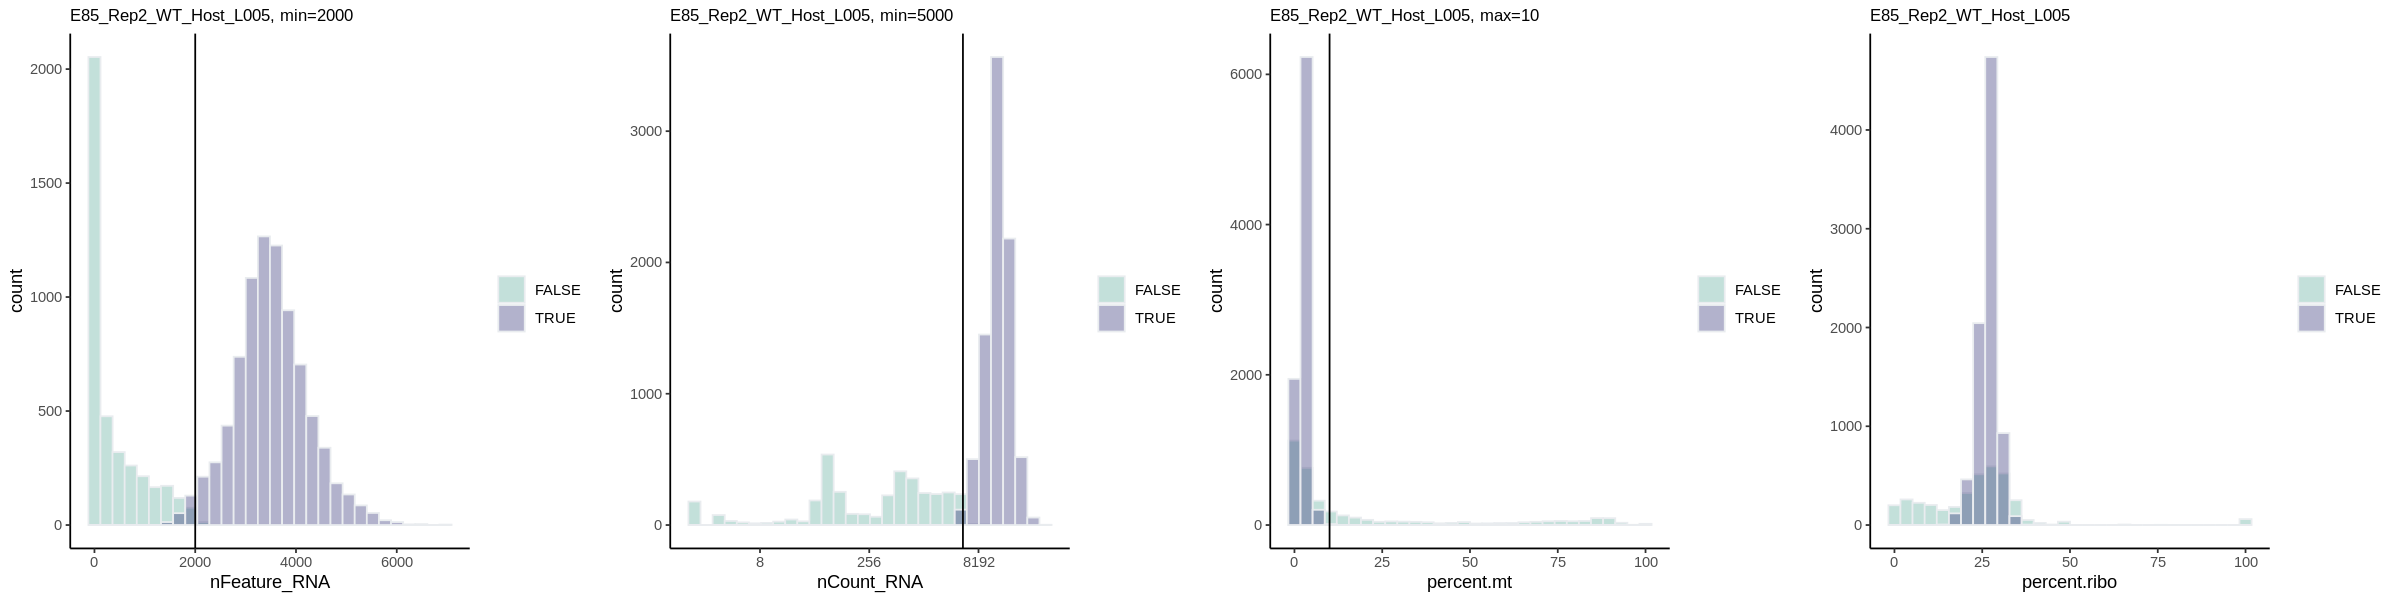

In [10]:
options(repr.plot.width=20, repr.plot.height=5)
options(warn=-1)

for (b in batches) {

    toplot <- data.frame(
      pass_QC = srat_sub_list[[b]]$pass_QC,
      nFeature_RNA = srat_sub_list[[b]]$nFeature_RNA,
      nCount_RNA = srat_sub_list[[b]]$nCount_RNA,
      percent.mt = srat_sub_list[[b]]$percent.mt,
      percent.ribo = srat_sub_list[[b]]$percent.ribo
    )

    p1 <- (ggplot(toplot, aes(x=nFeature_RNA, fill=pass_QC)) +
        geom_histogram( color="#e9ecef", alpha=0.4, position = 'identity') +
        scale_fill_manual(values=c("#69b3a2", "#404080")) +
        labs(fill="") +
        geom_vline(xintercept=io$min_nFeature_RNA[[opts$experiment]][[b]]) +
        ggtitle(paste0(b, ", min=", io$min_nFeature_RNA[[opts$experiment]][[b]])) +
        theme_classic() +
        theme(plot.title = element_text(size = 10)))

    p2 <- (ggplot(toplot, aes(x=nCount_RNA, fill=pass_QC)) +
        geom_histogram( color="#e9ecef", alpha=0.4, position = 'identity') +
        scale_fill_manual(values=c("#69b3a2", "#404080")) +
        labs(fill="") +
        scale_x_continuous(trans='log2') +
        geom_vline(xintercept=io$min_nCount_RNA[[opts$experiment]][[b]]) +
        ggtitle(paste0(b, ", min=", io$min_nCount_RNA[[opts$experiment]][[b]])) +
        theme_classic() +
        theme(plot.title = element_text(size = 10)))

    p3 <- (ggplot(toplot, aes(x=percent.mt, fill=pass_QC)) +
        geom_histogram( color="#e9ecef", alpha=0.4, position = 'identity') +
        scale_fill_manual(values=c("#69b3a2", "#404080")) +
        labs(fill="") +
        geom_vline(xintercept=io$max_percent.mt[[opts$experiment]][[b]]) +
        ggtitle(paste0(b, ", max=", io$max_percent.mt[[opts$experiment]][[b]])) +
        theme_classic() +
        theme(plot.title = element_text(size = 10)))

    p4 <- (ggplot(toplot, aes(x=percent.ribo, fill=pass_QC)) +
        geom_histogram( color="#e9ecef", alpha=0.4, position = 'identity') +
        scale_fill_manual(values=c("#69b3a2", "#404080")) +
        labs(fill="") +
        ggtitle(b) +
        theme_classic() +
        theme(plot.title = element_text(size = 10)))

    grid.arrange(p1, p2, p3, p4, ncol=4)

}
options(warn=0)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



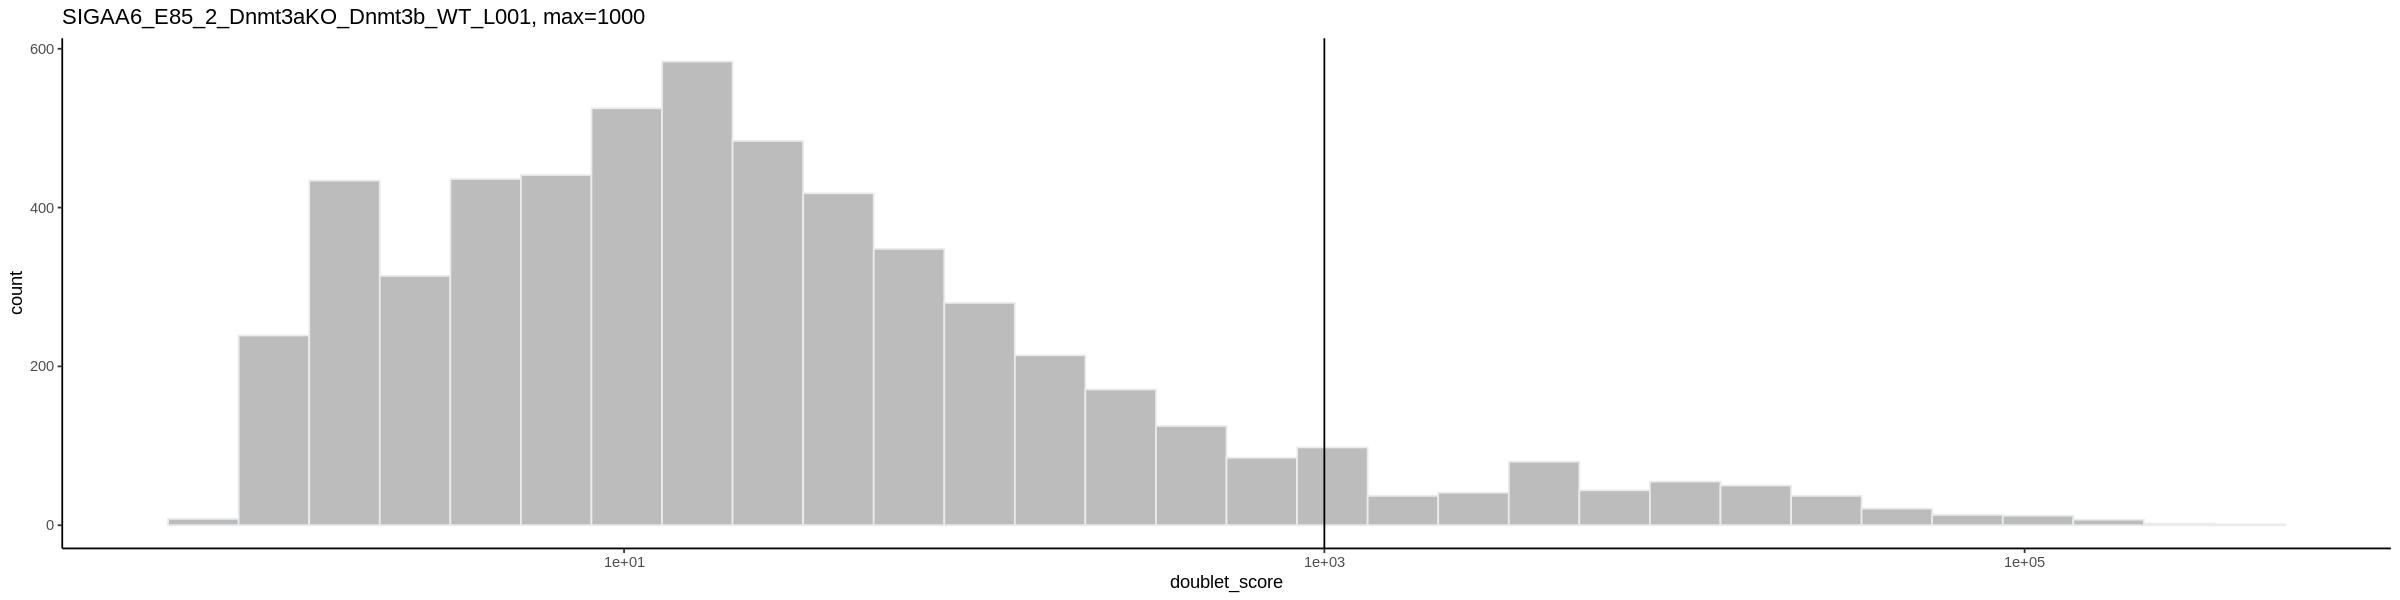

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



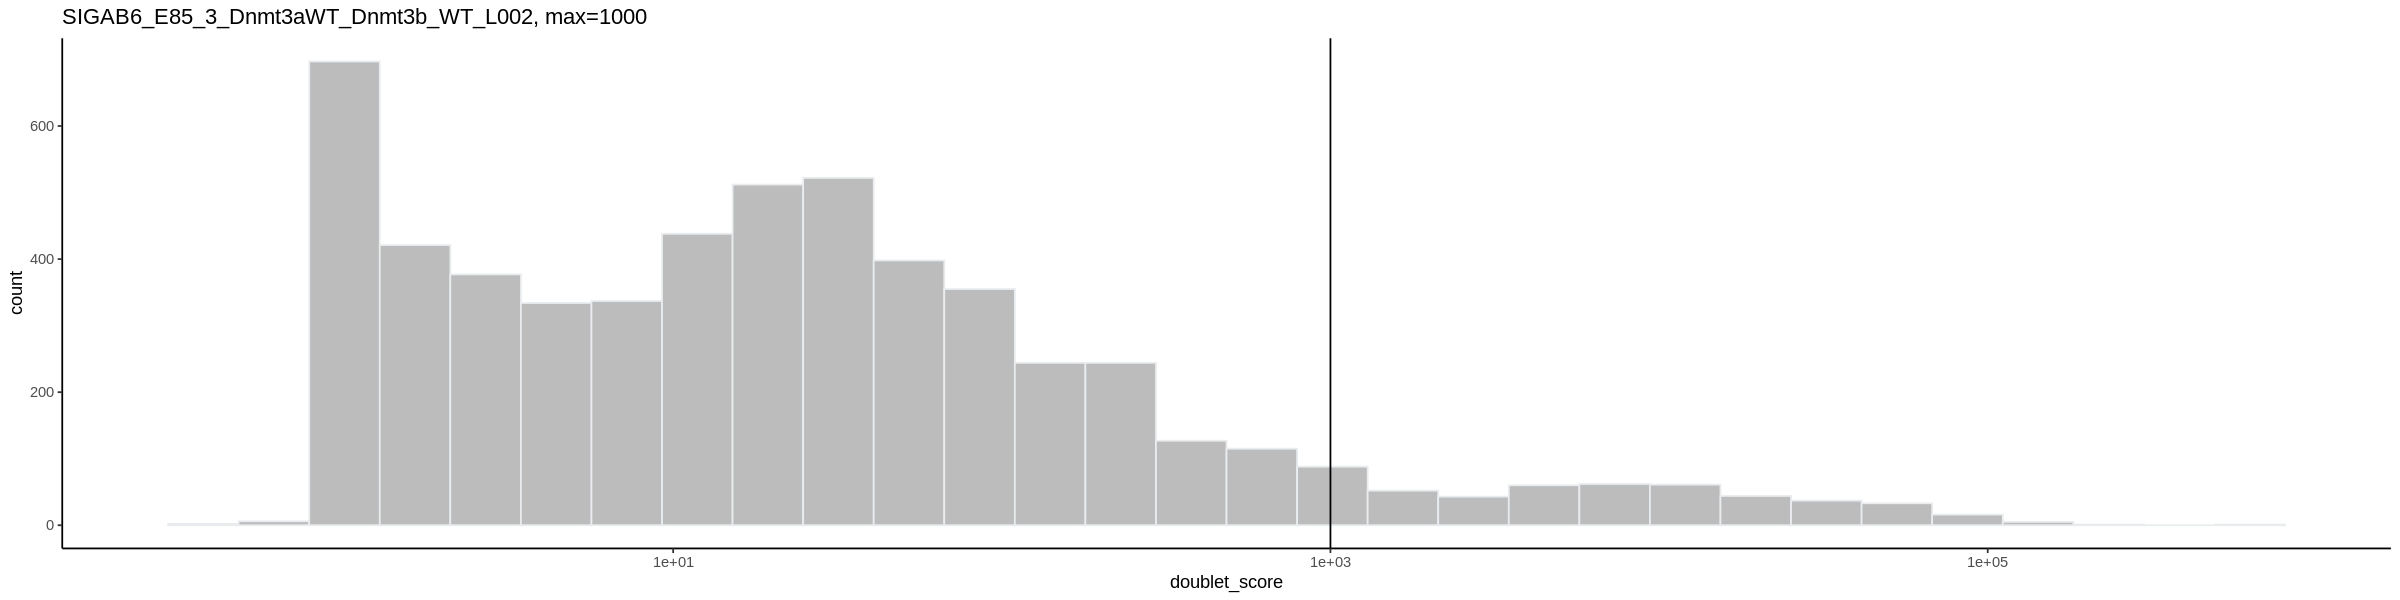

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



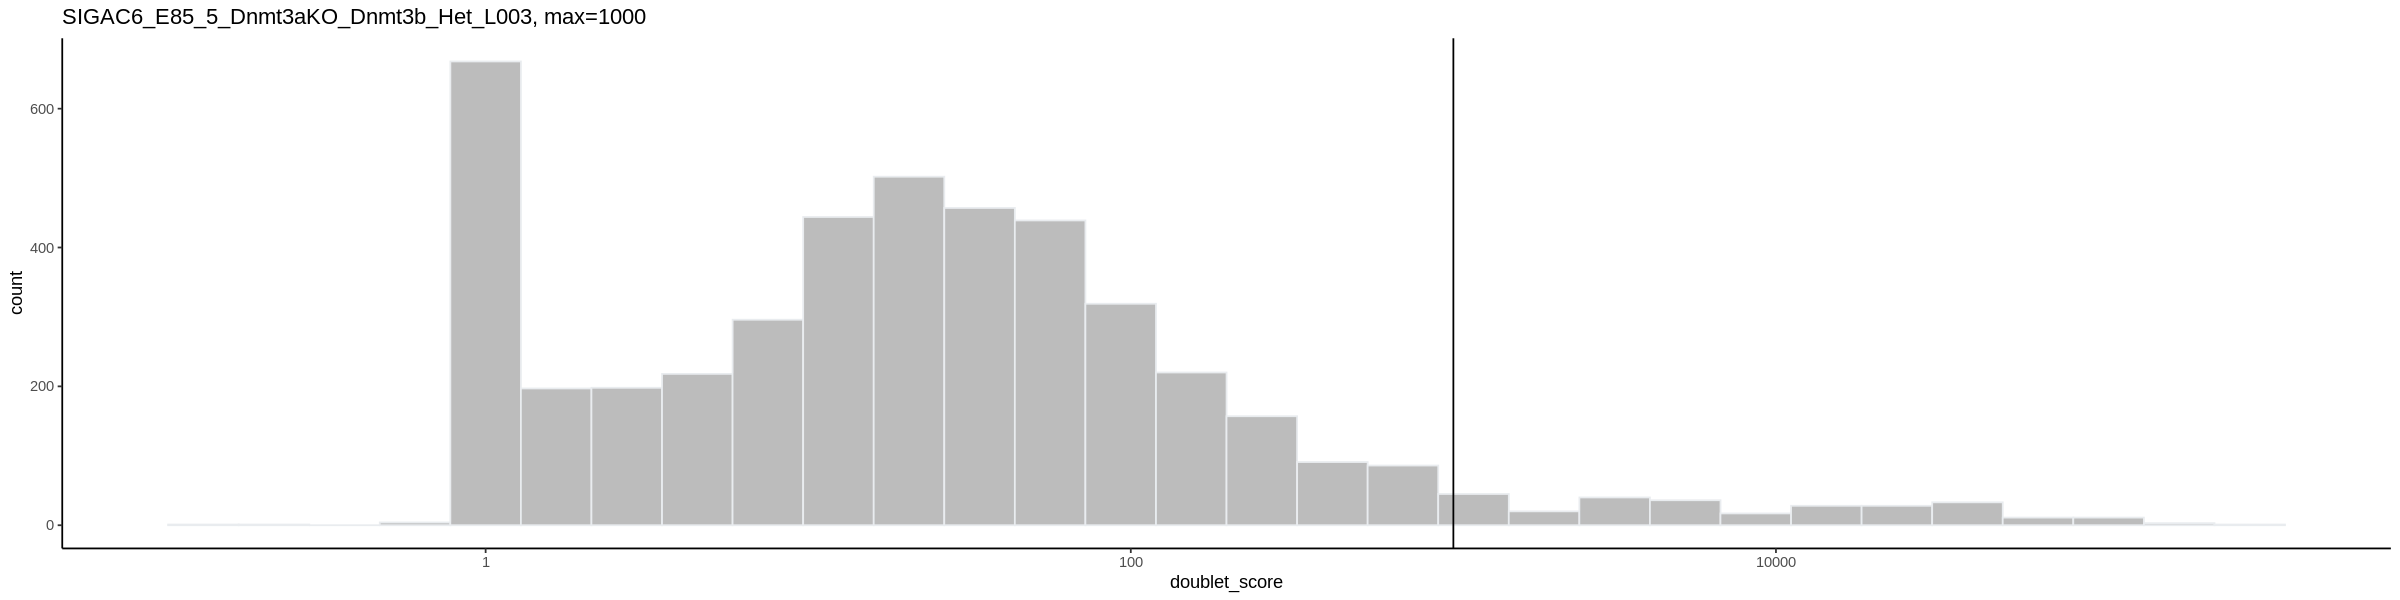

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



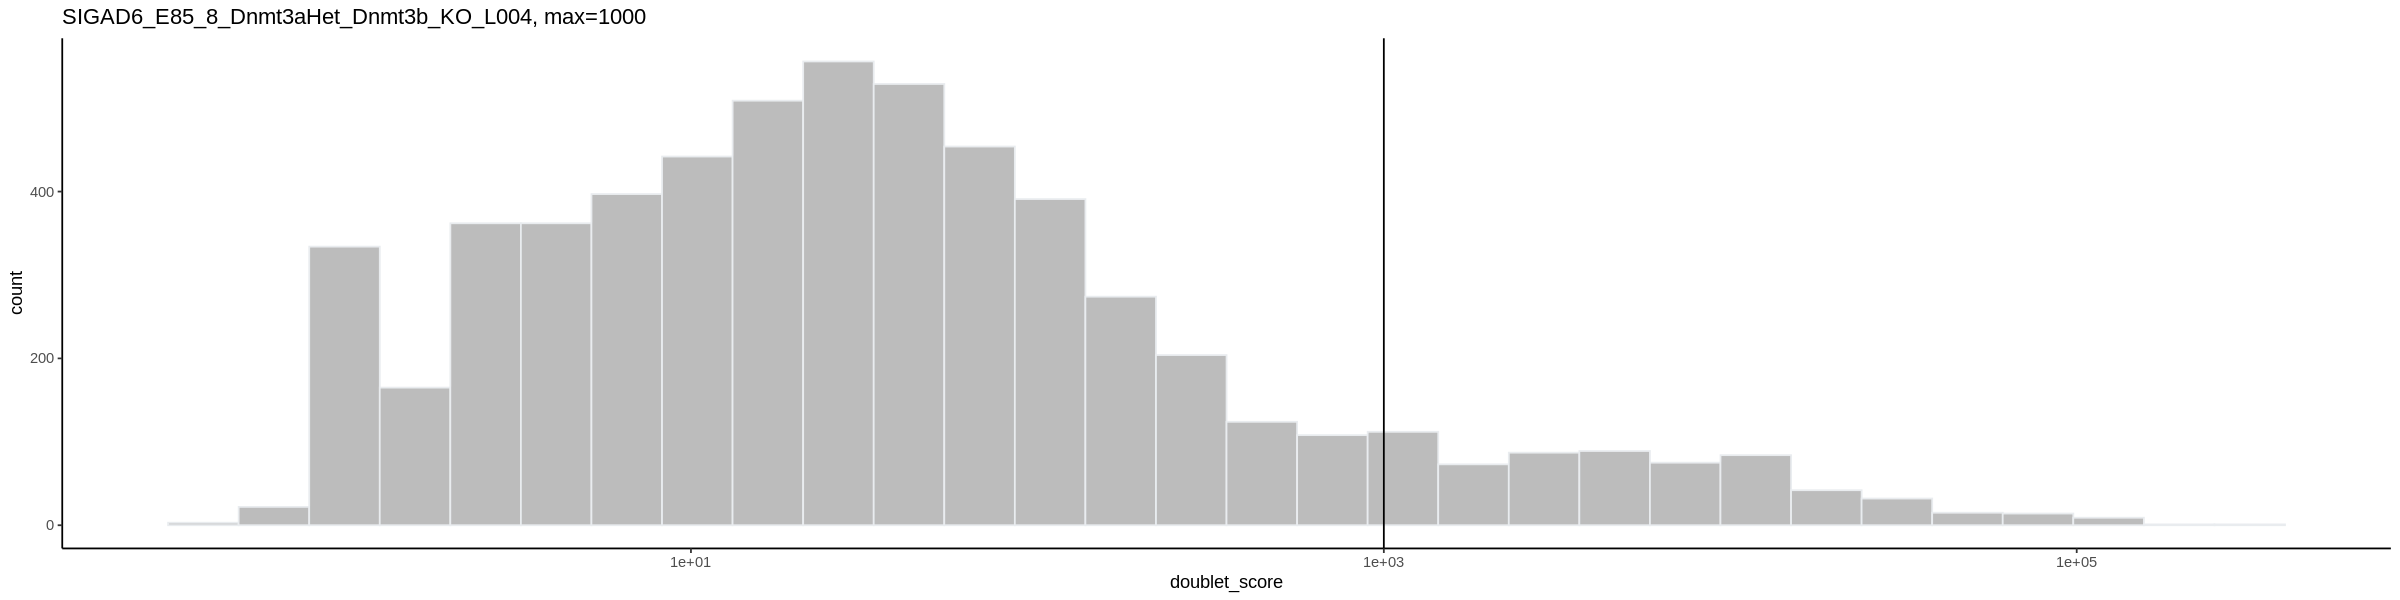

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



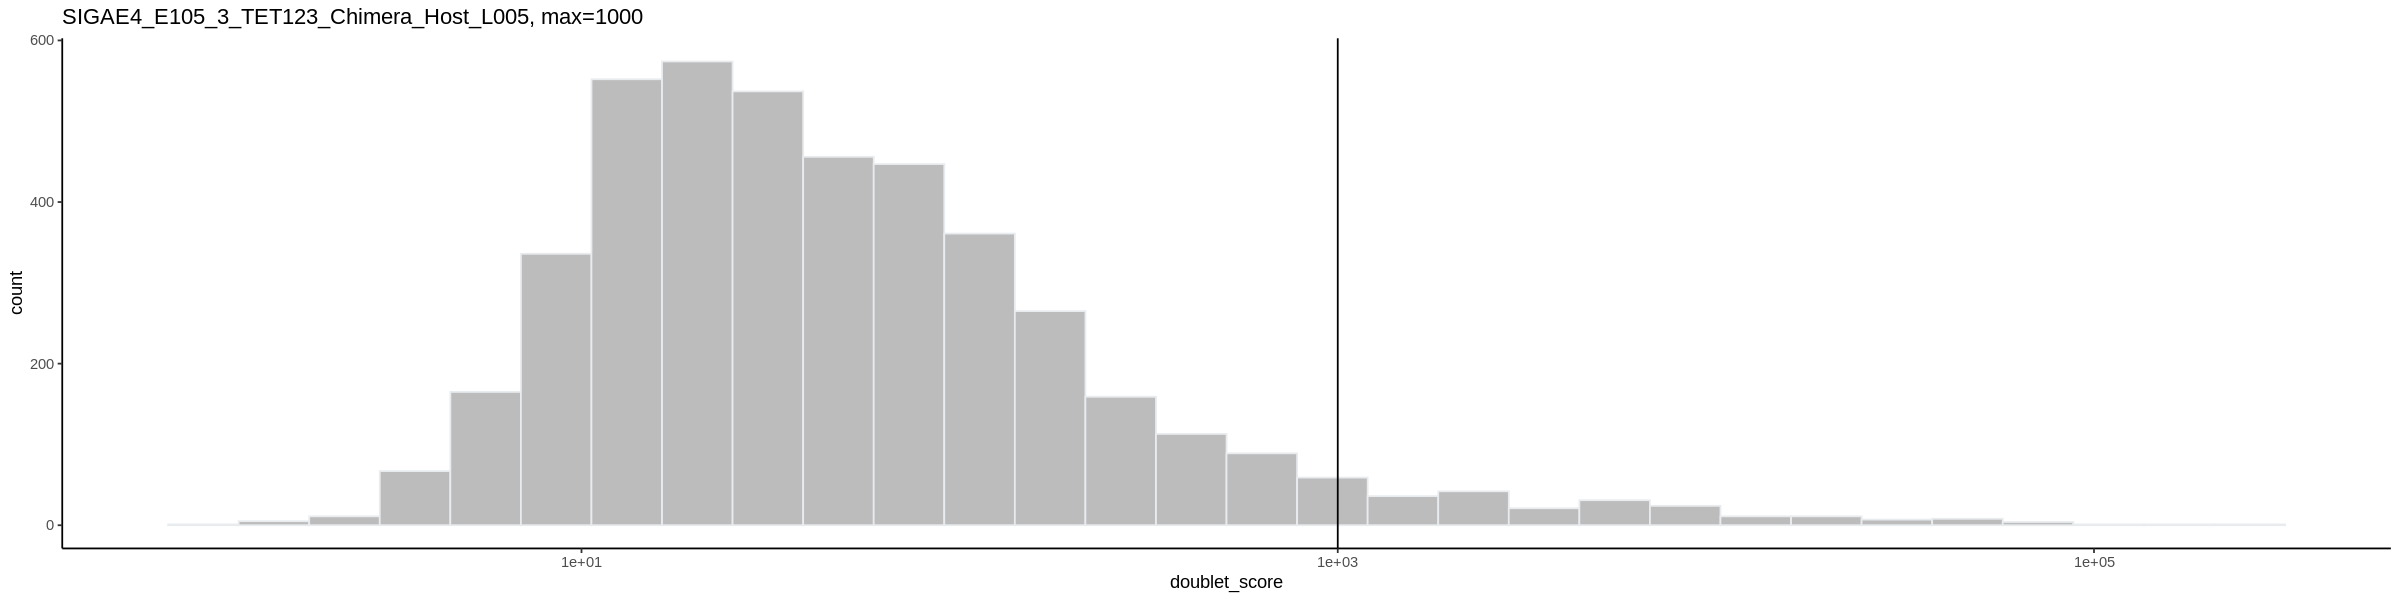

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



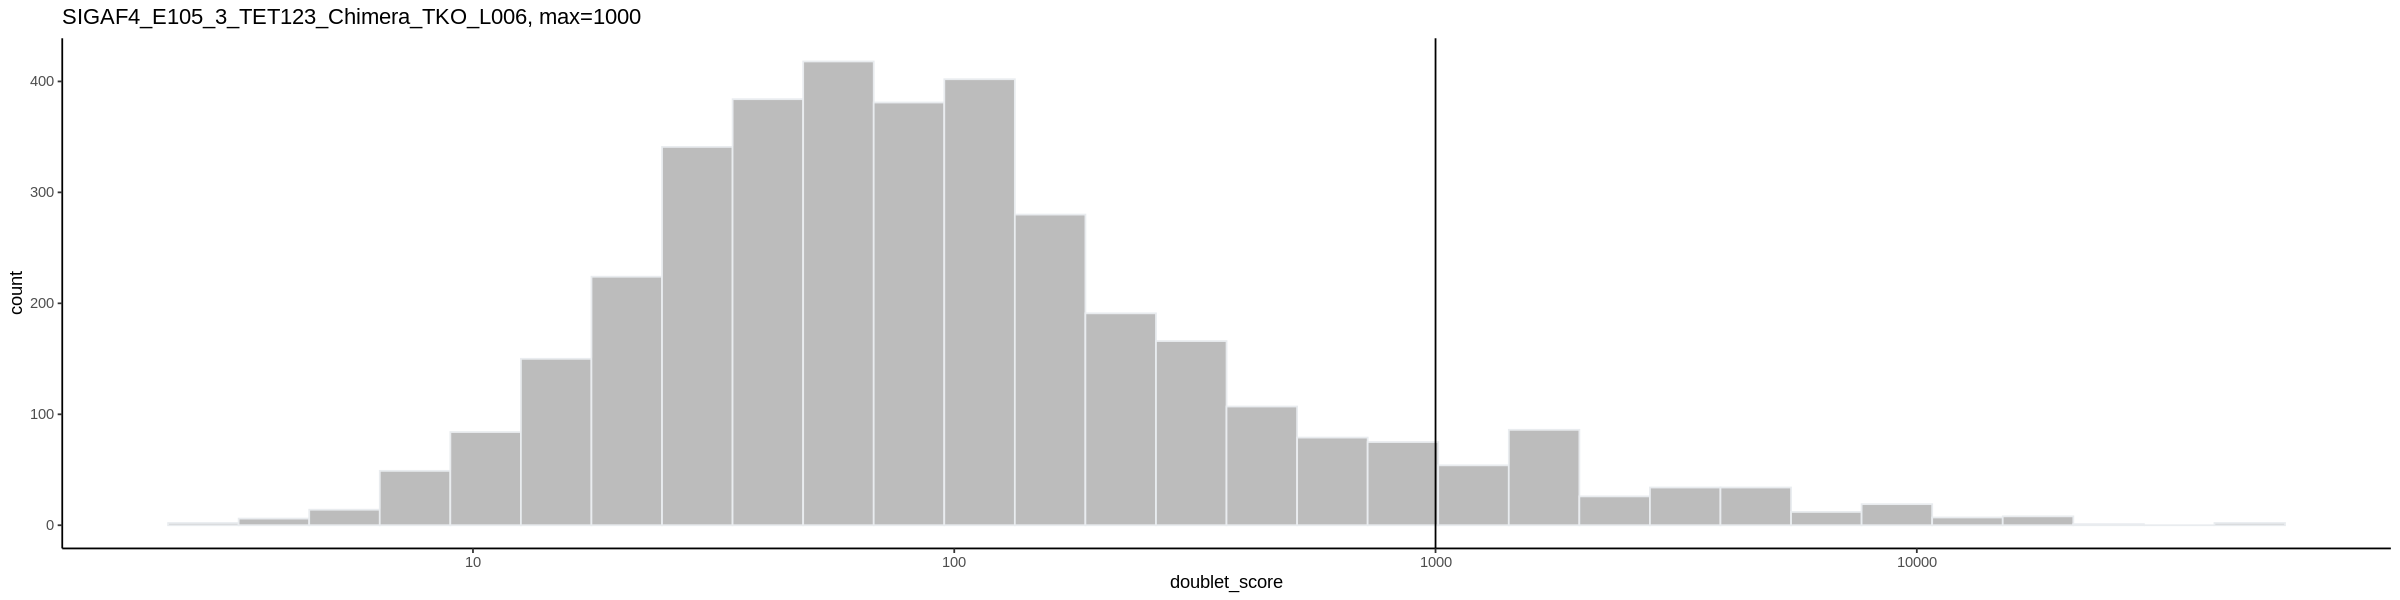

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



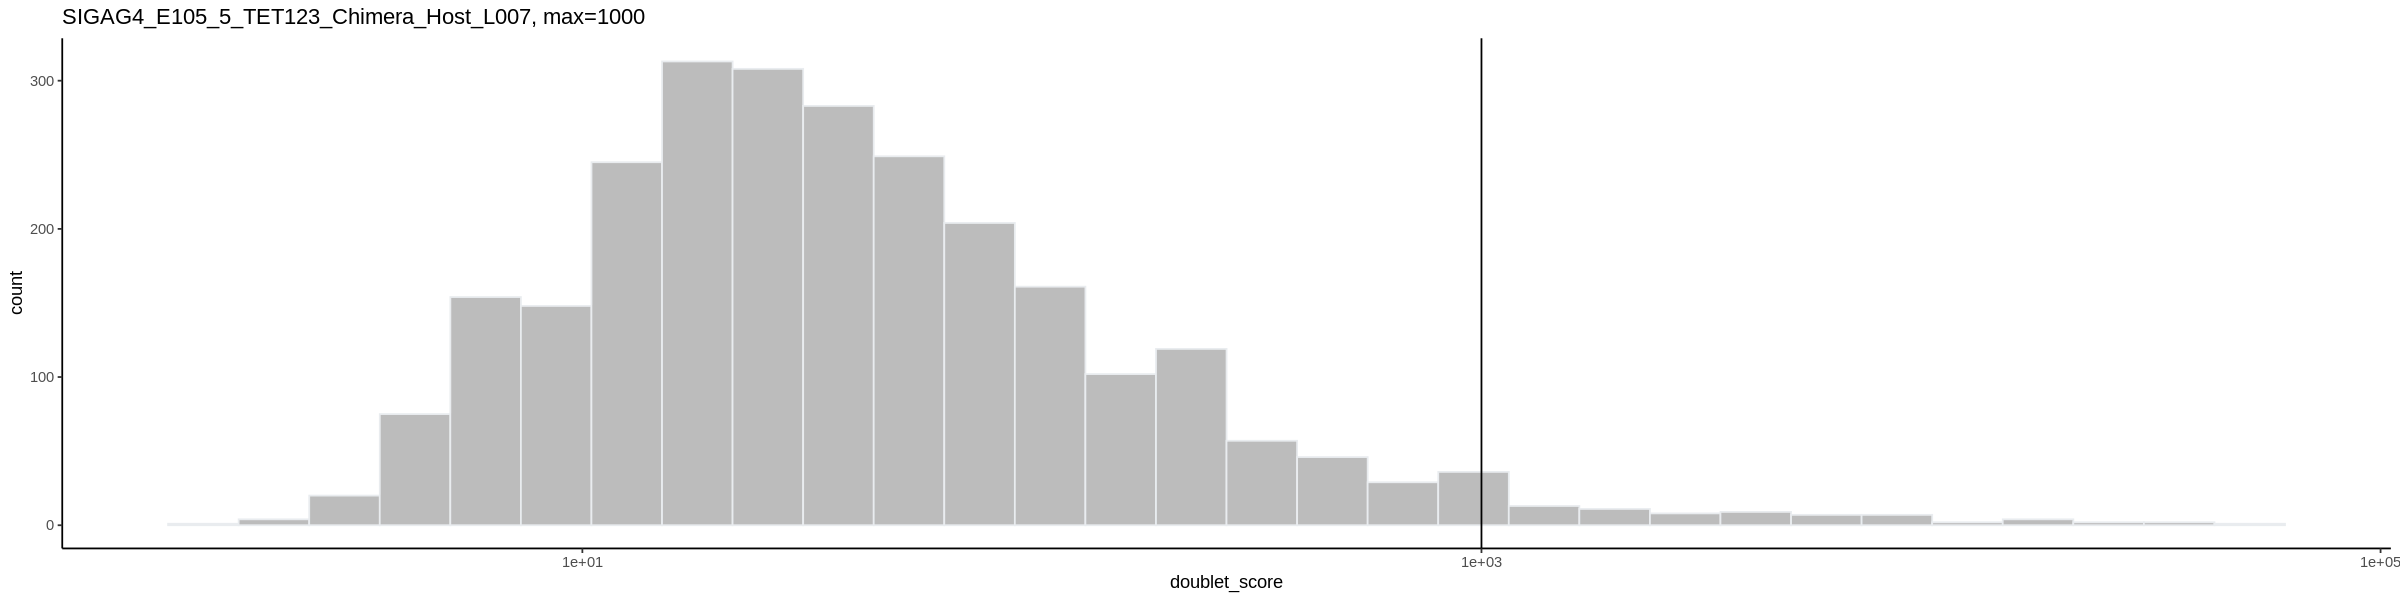

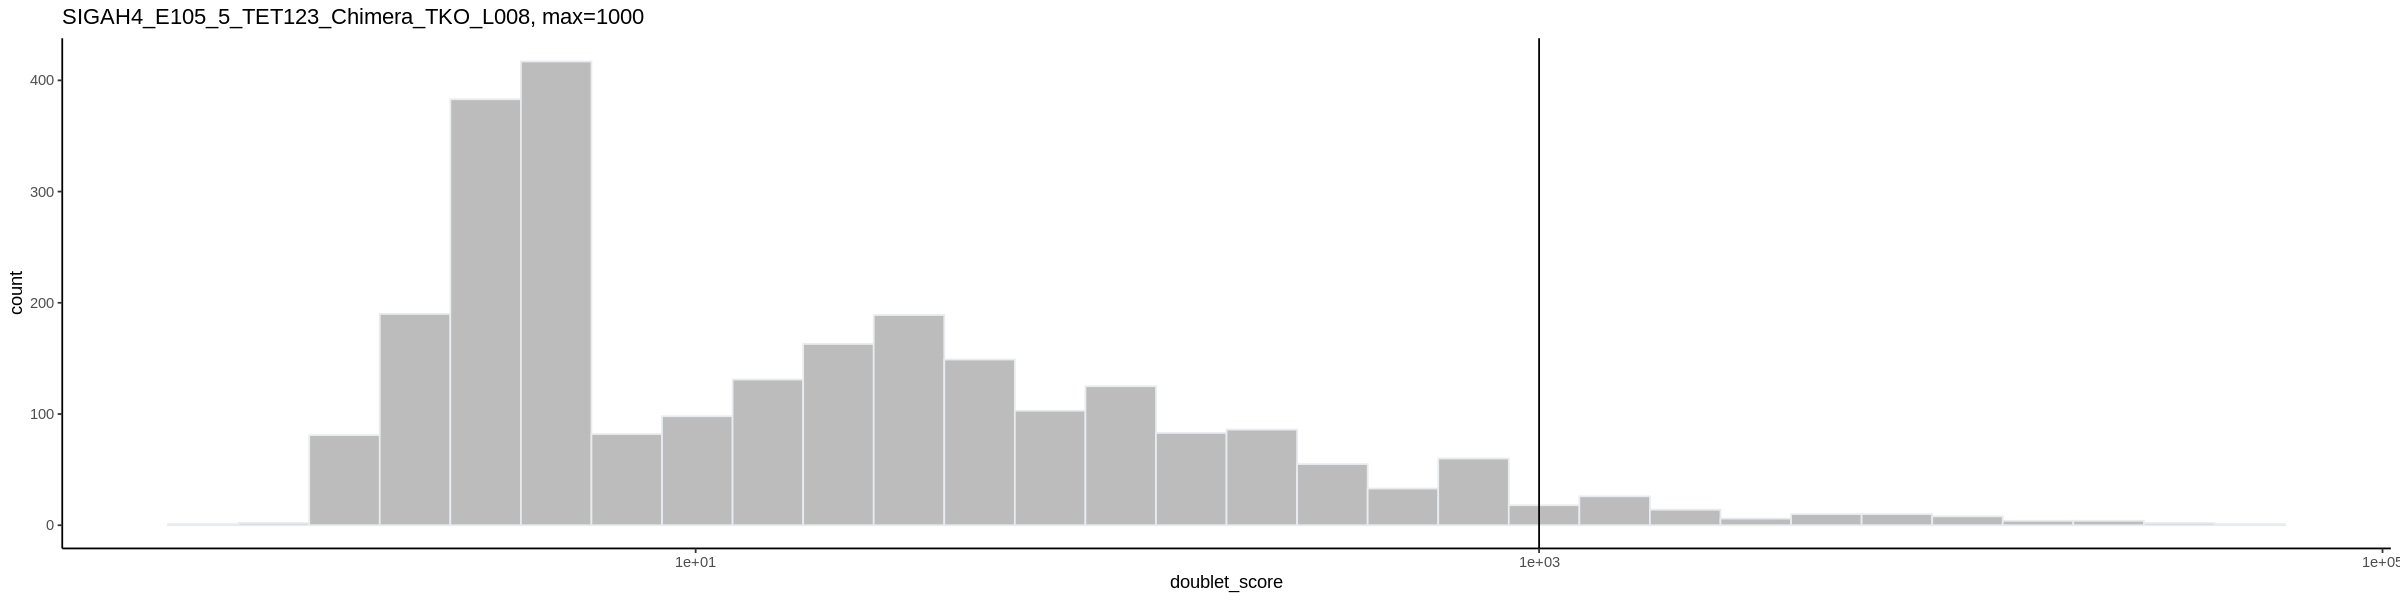

In [11]:
options(repr.plot.width=20, repr.plot.height=5)
options(warn=-1)

for (b in batches) {

    toplot <- data.frame(
      doublet_score = srat_sub_list[[b]]$doublet_score
    )

    p1 <- (ggplot(toplot, aes(x=doublet_score)) +
        geom_histogram( color="#e9ecef", alpha=0.4, position = 'identity') +
        scale_fill_manual(values=c("#69b3a2")) +
        labs(fill="") +
        scale_x_continuous(trans='log10') +
        geom_vline(xintercept=io$max_doublet_score[[opts$experiment]][[b]]) +
        ggtitle(paste0(b, ", max=", io$max_doublet_score[[opts$experiment]][[b]])) +
        theme_classic())

    print(p1)
}
options(warn=0)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



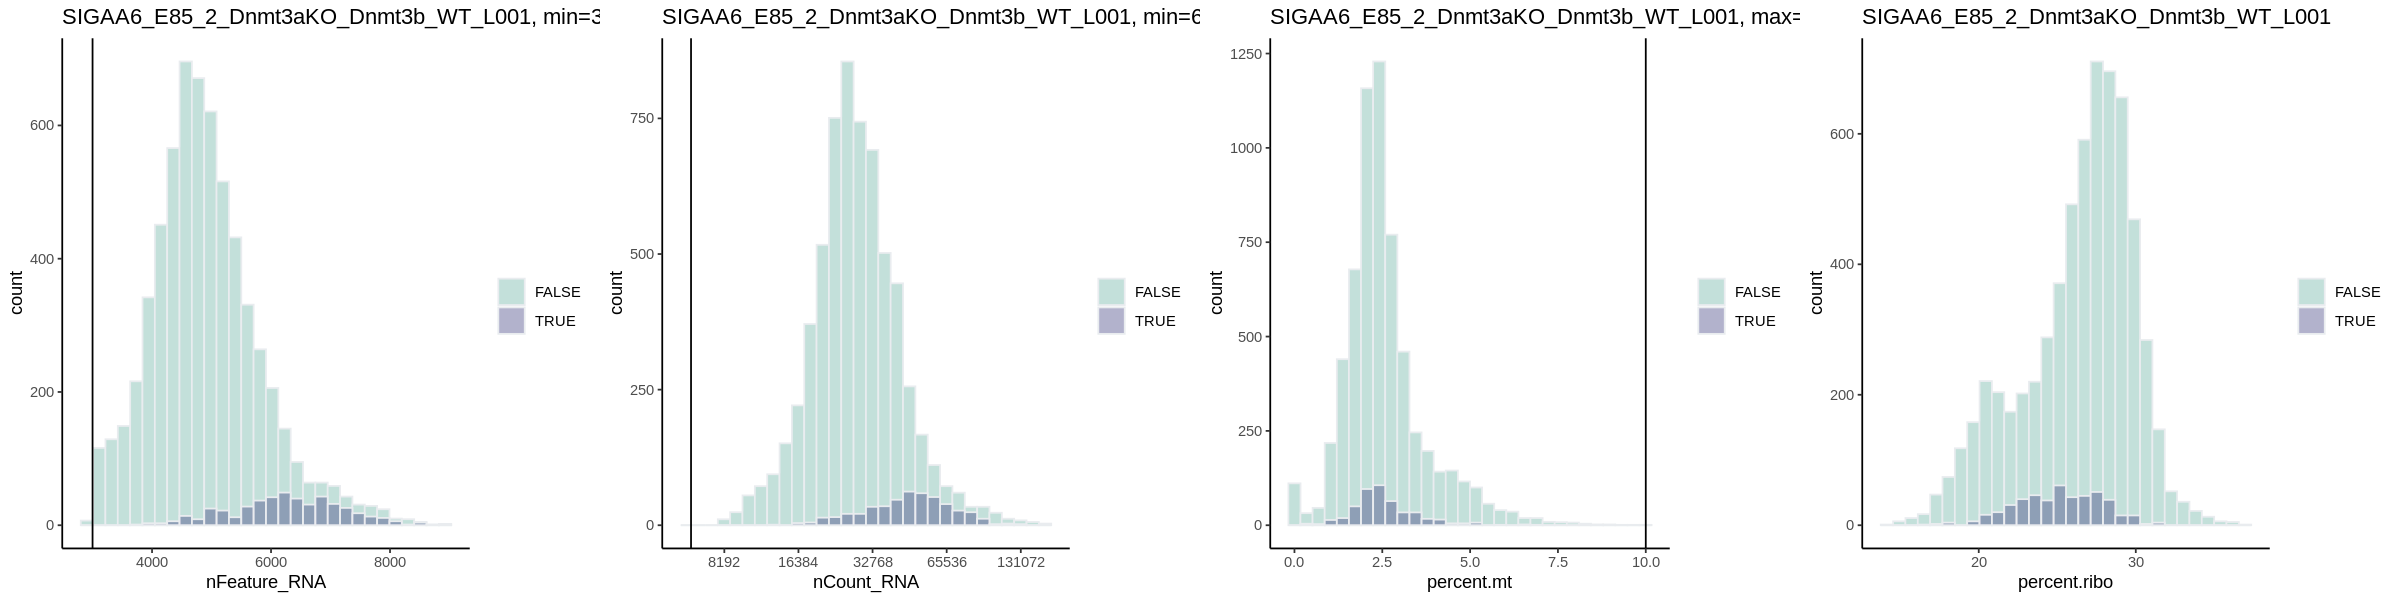

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



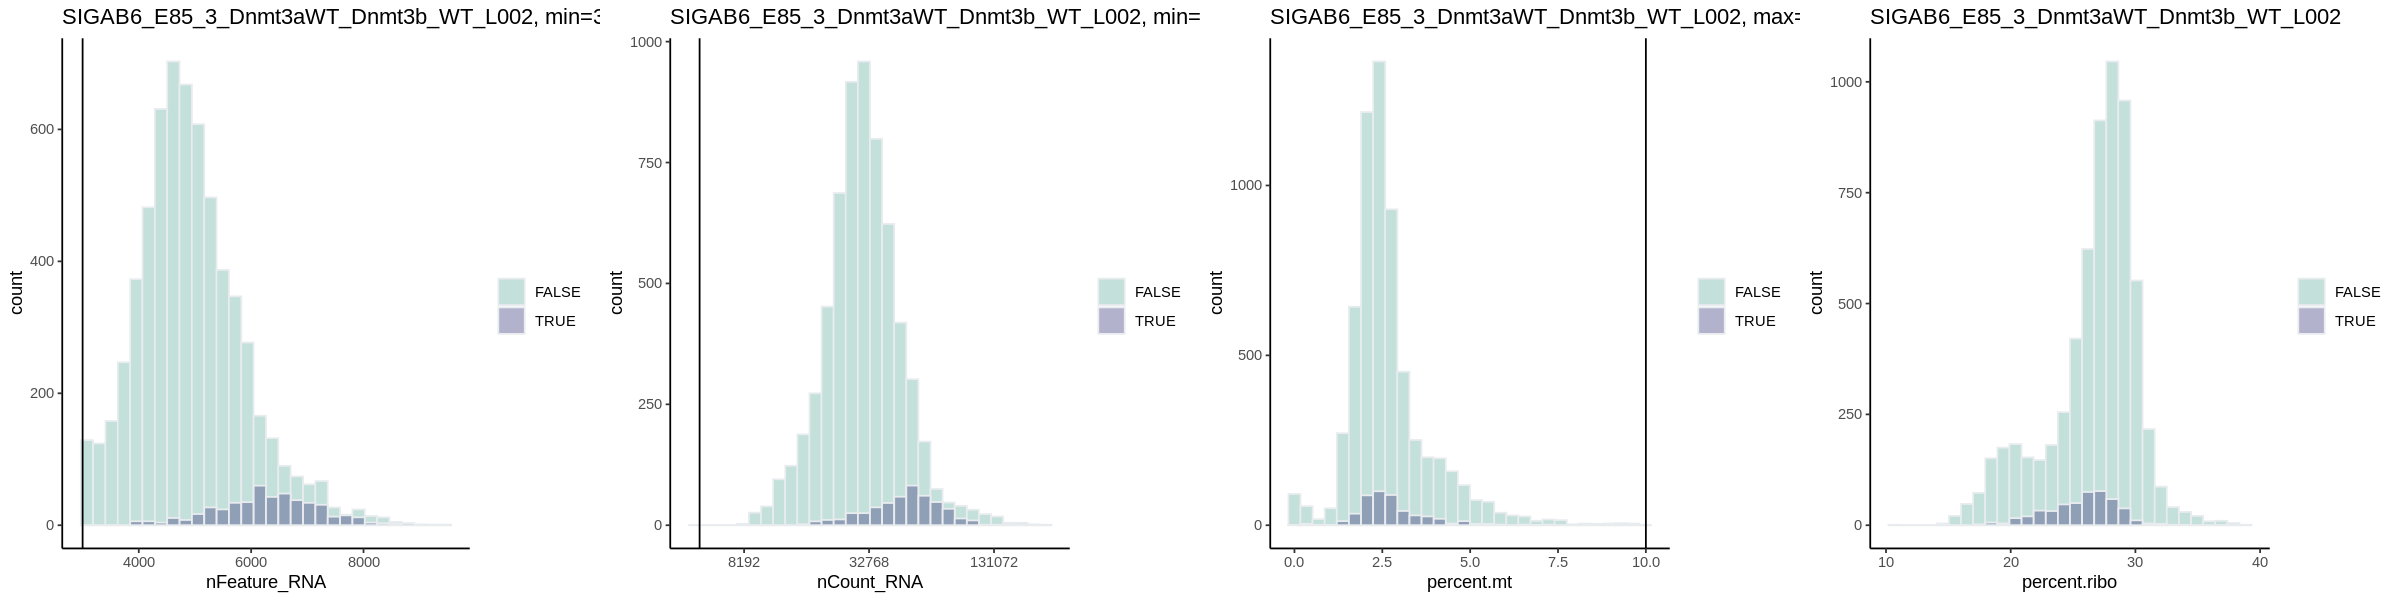

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



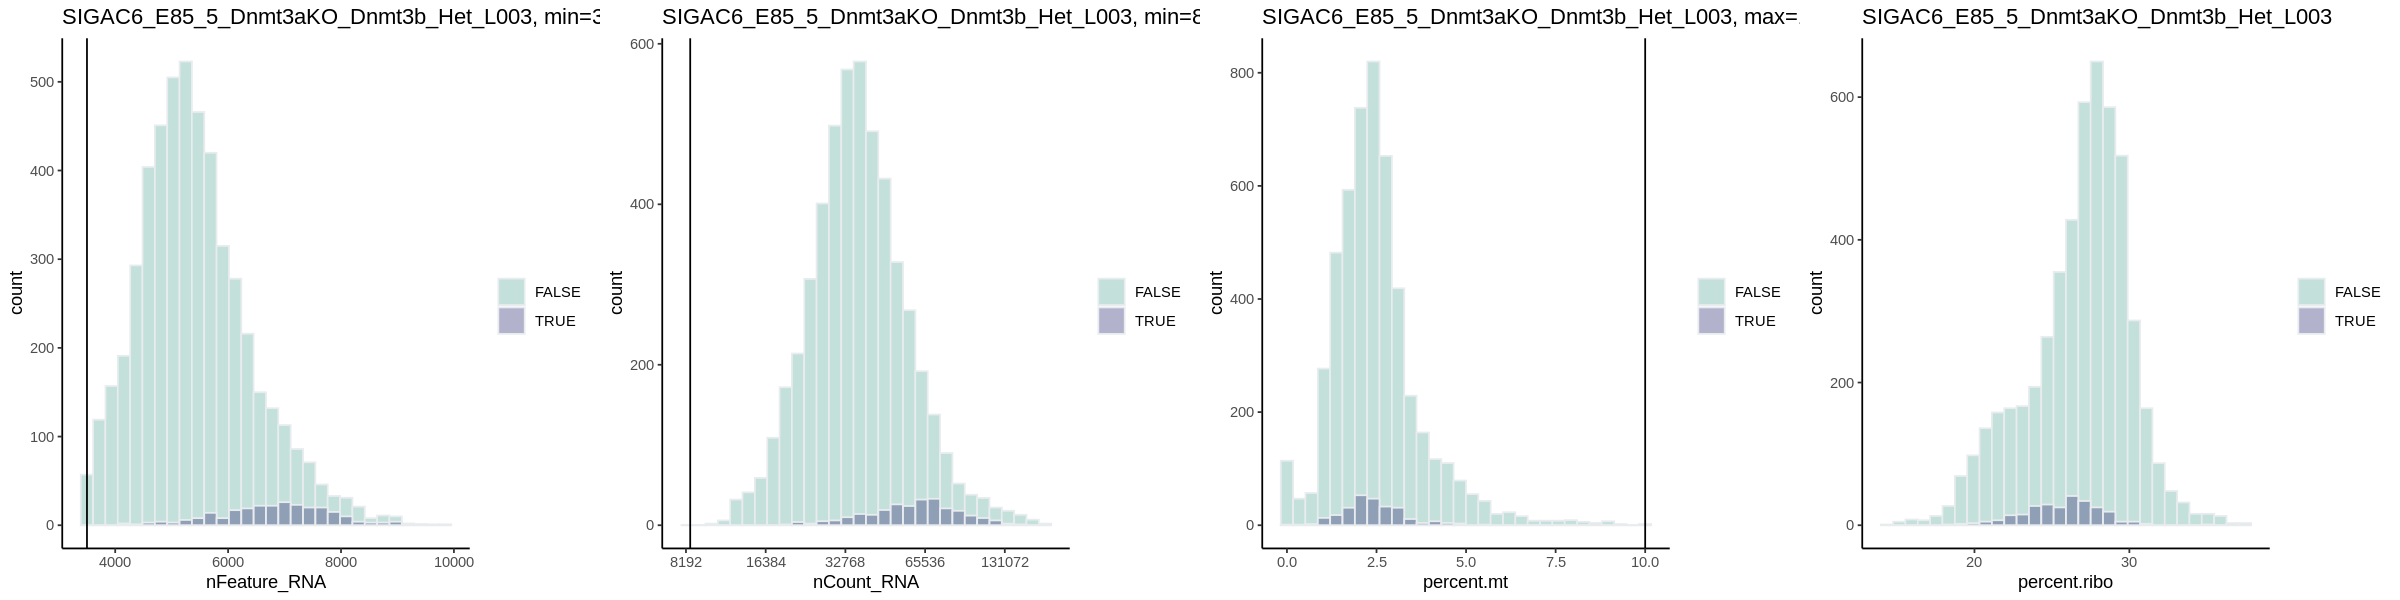

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



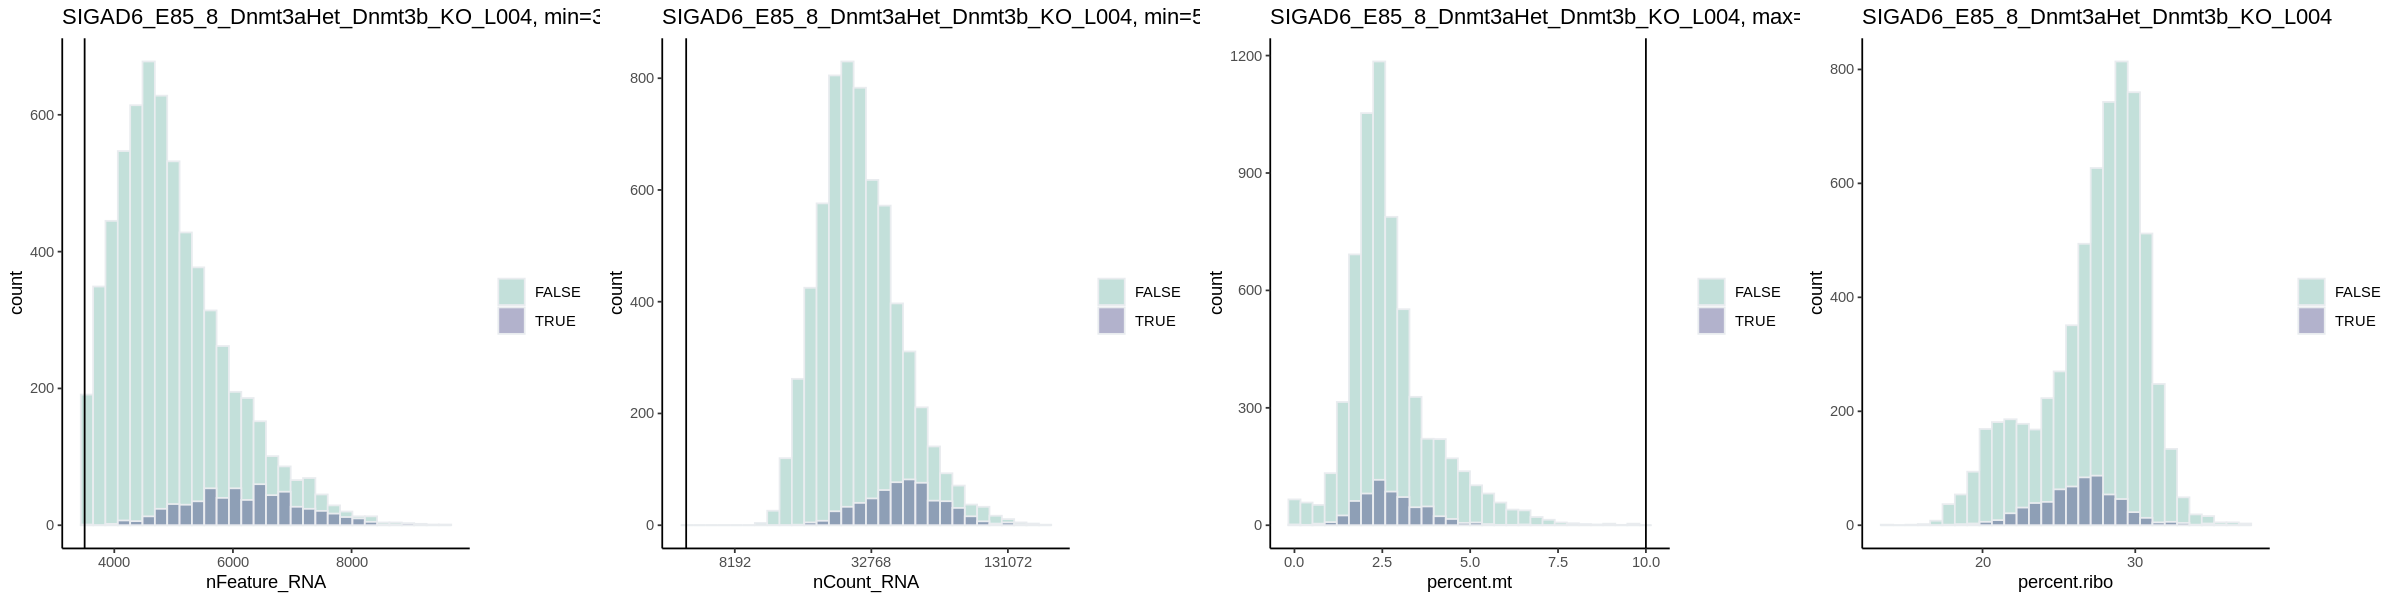

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



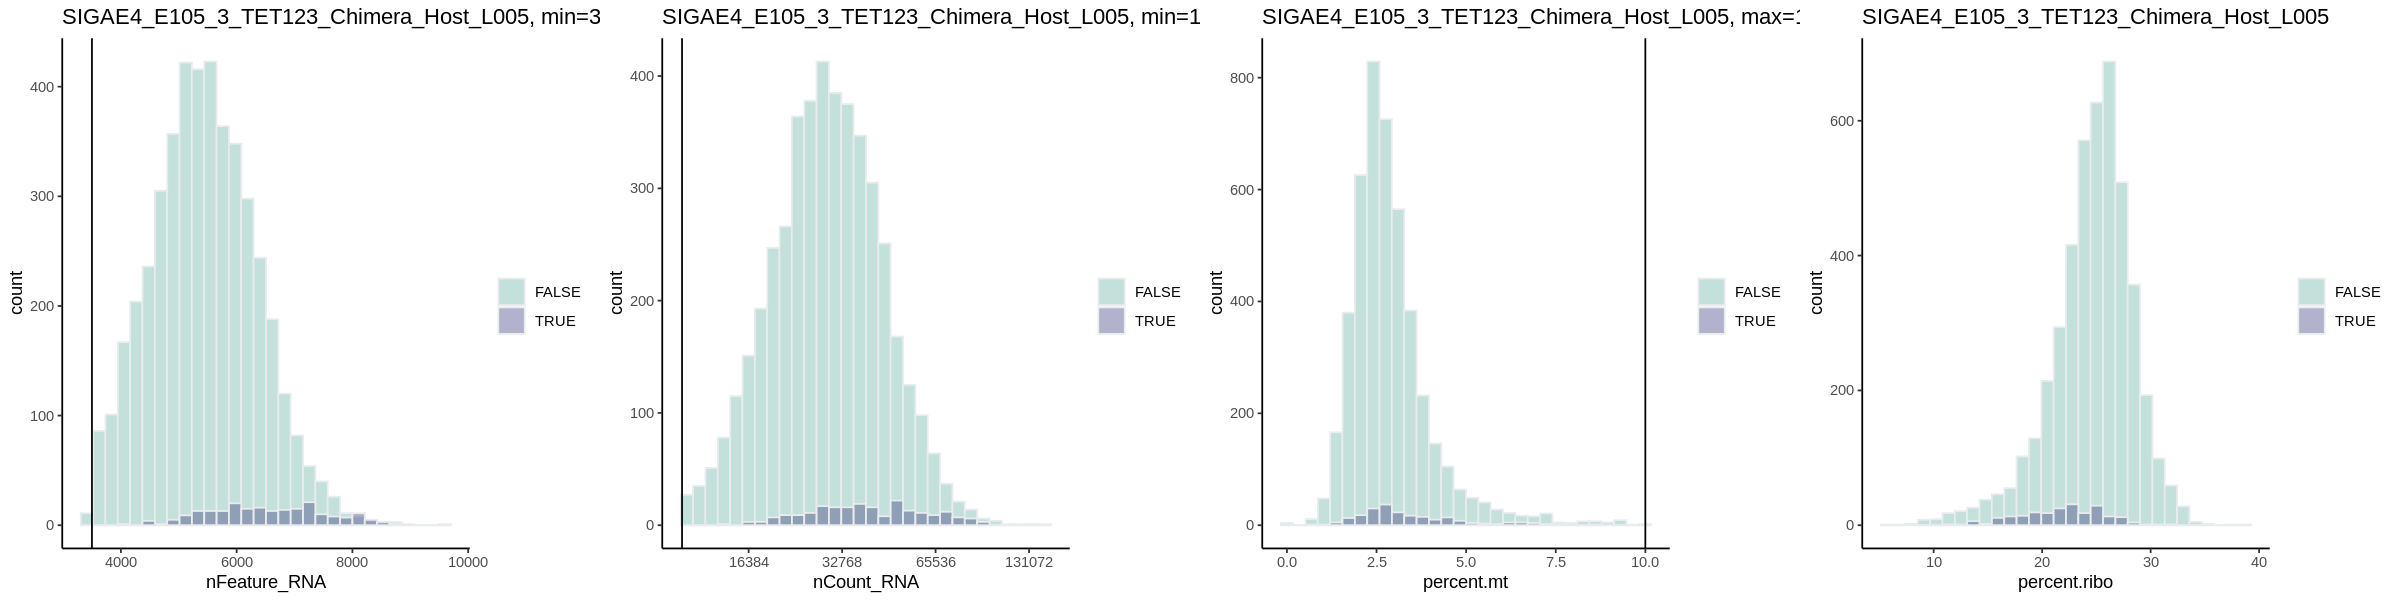

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



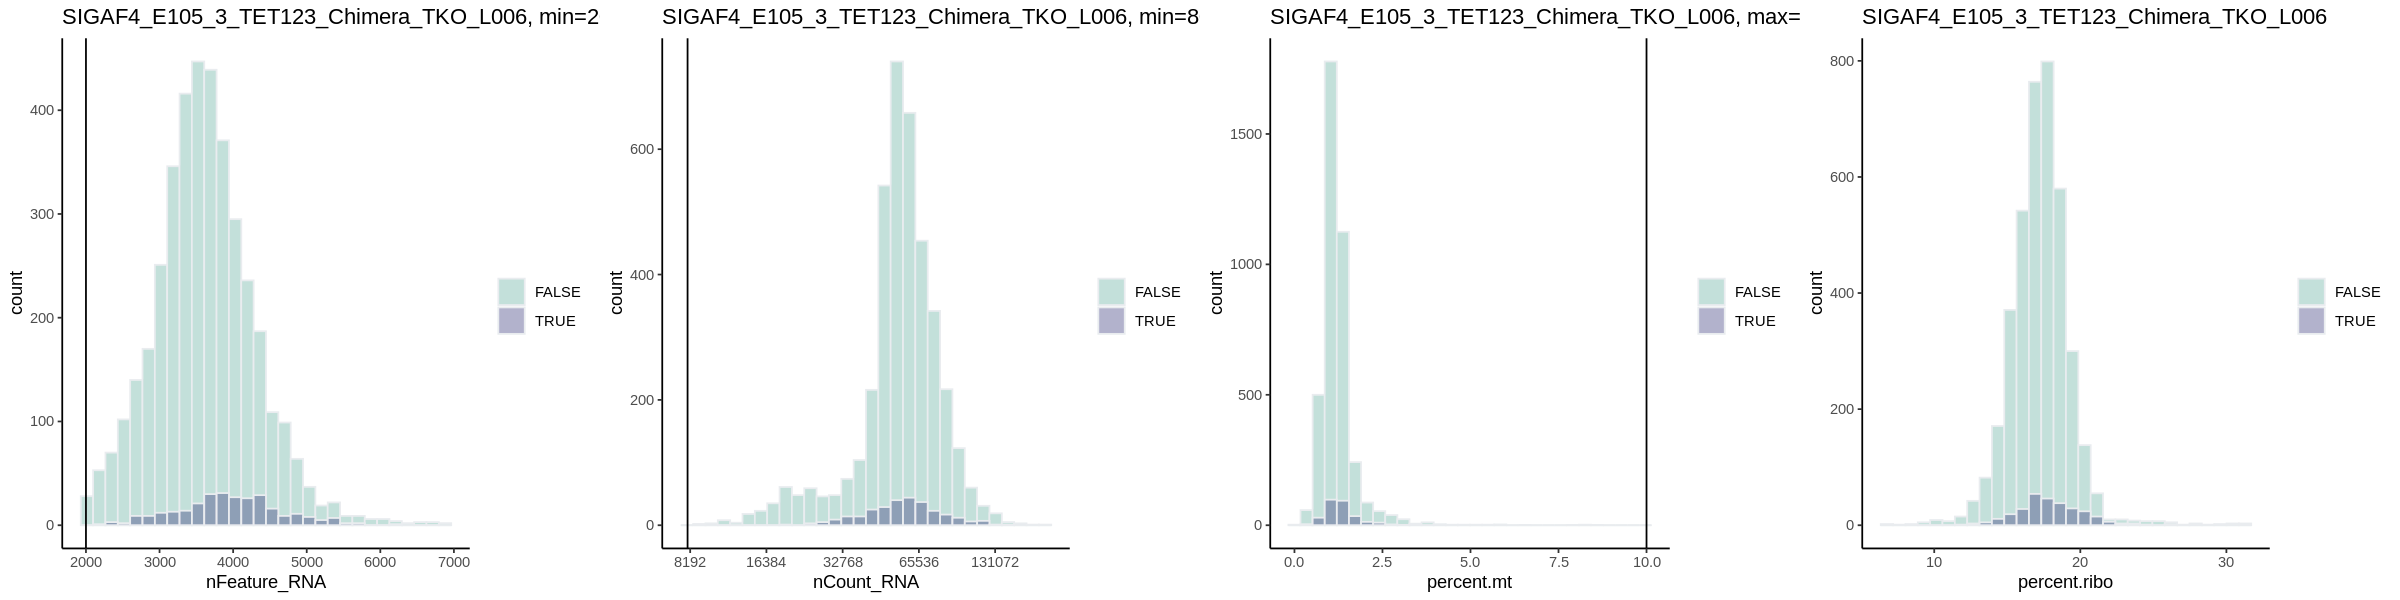

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



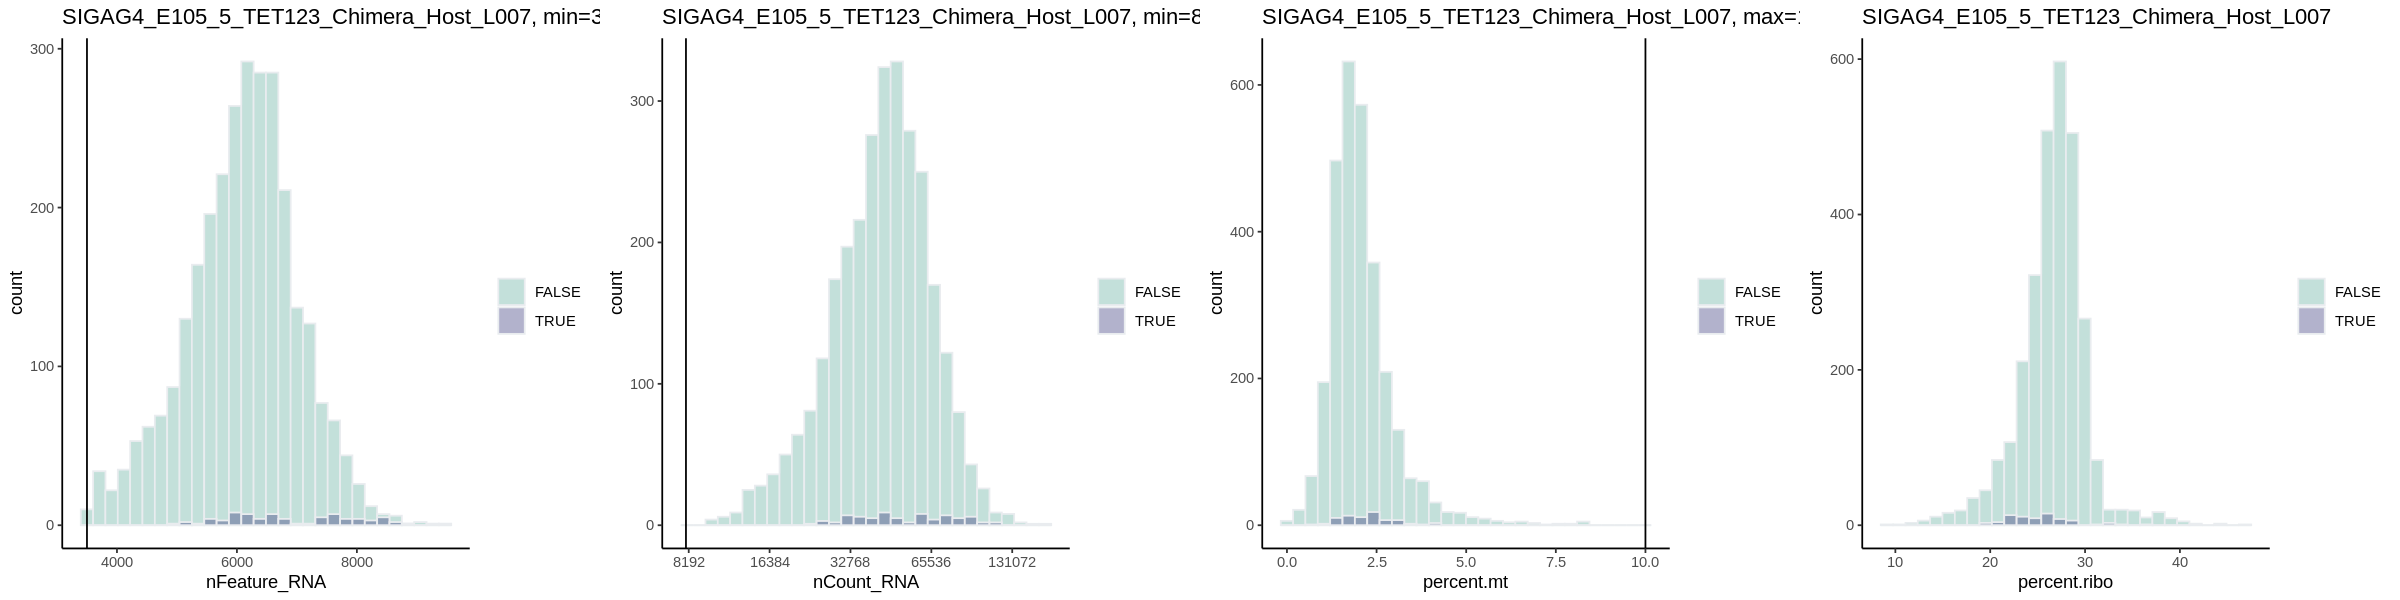

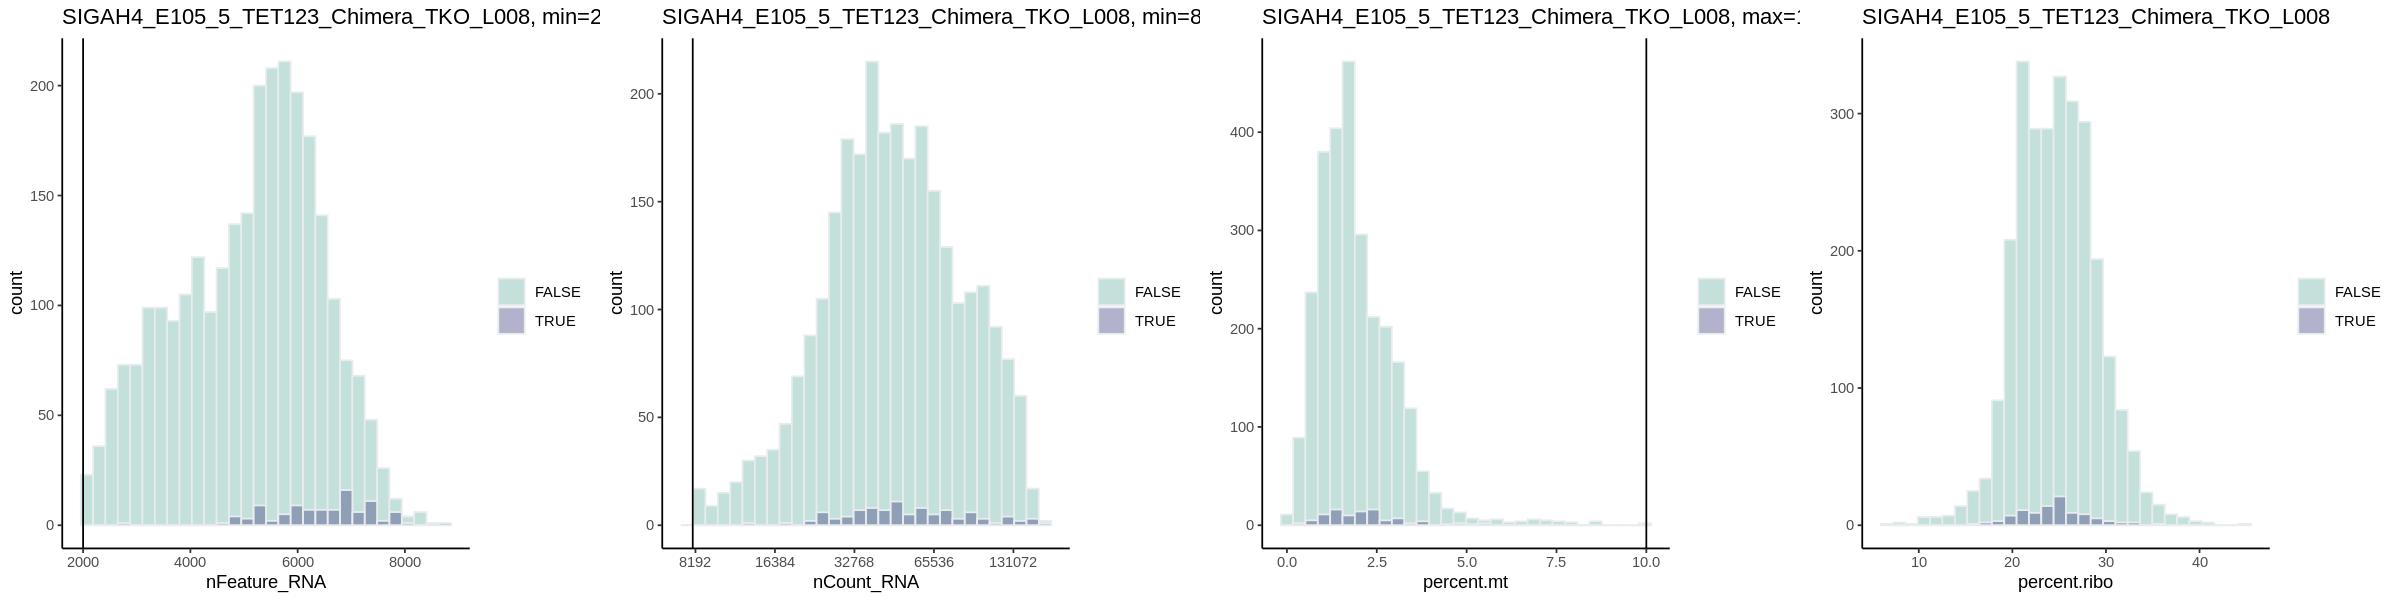

In [13]:
options(repr.plot.width=20, repr.plot.height=5)
options(warn=-1)

for (b in batches) {

    toplot <- data.frame(
      doublet = srat_sub_list_pass_QC[[b]]$doublet_score > io$max_doublet_score[[opts$experiment]][[b]],
      nFeature_RNA = srat_sub_list_pass_QC[[b]]$nFeature_RNA,
      nCount_RNA = srat_sub_list_pass_QC[[b]]$nCount_RNA,
      percent.mt = srat_sub_list_pass_QC[[b]]$percent.mt,
      percent.ribo = srat_sub_list_pass_QC[[b]]$percent.ribo
    )

    p1 <- (ggplot(toplot, aes(x=nFeature_RNA, fill=doublet)) +
        geom_histogram( color="#e9ecef", alpha=0.4, position = 'identity') +
        scale_fill_manual(values=c("#69b3a2", "#404080")) +
        labs(fill="") +
        geom_vline(xintercept=io$min_nFeature_RNA[[opts$experiment]][[b]]) +
        ggtitle(paste0(b, ", min=", io$min_nFeature_RNA[[opts$experiment]][[b]])) +
        theme_classic())

    p2 <- (ggplot(toplot, aes(x=nCount_RNA, fill=doublet)) +
        geom_histogram( color="#e9ecef", alpha=0.4, position = 'identity') +
        scale_fill_manual(values=c("#69b3a2", "#404080")) +
        labs(fill="") +
        scale_x_continuous(trans='log2') +
        geom_vline(xintercept=io$min_nCount_RNA[[opts$experiment]][[b]]) +
        ggtitle(paste0(b, ", min=", io$min_nCount_RNA[[opts$experiment]][[b]])) +
        theme_classic())

    p3 <- (ggplot(toplot, aes(x=percent.mt, fill=doublet)) +
        geom_histogram( color="#e9ecef", alpha=0.4, position = 'identity') +
        scale_fill_manual(values=c("#69b3a2", "#404080")) +
        labs(fill="") +
        geom_vline(xintercept=io$max_percent.mt[[opts$experiment]][[b]]) +
        ggtitle(paste0(b, ", max=", io$max_percent.mt[[opts$experiment]][[b]])) +
        theme_classic())

    p4 <- (ggplot(toplot, aes(x=percent.ribo, fill=doublet)) +
        geom_histogram( color="#e9ecef", alpha=0.4, position = 'identity') +
        scale_fill_manual(values=c("#69b3a2", "#404080")) +
        labs(fill="") +
        ggtitle(b) +
        theme_classic())

    grid.arrange(p1, p2, p3, p4, ncol=4)

}
options(warn=0)

In [14]:
md

,orig.ident,nCount_RNA,nFeature_RNA,barcode,SIG,stage,embryo,class,target,modification,lane,batch,cell,percent.mt,percent.ribo,pass_QC,doublet_score
,<fct>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<lgl>,<dbl>
cell_88332,cell,2,2,AAACCCAAGACGGTTG-1,SIGAH4,E105,5,TET123,Chimera,TKO,L008,SIGAH4_E105_5_TET123_Chimera_TKO_L008,cell_88332,0.00000000,50.000000,FALSE,NA
cell_88333,cell,201,131,AAACCCAAGGAATCGC-1,SIGAH4,E105,5,TET123,Chimera,TKO,L008,SIGAH4_E105_5_TET123_Chimera_TKO_L008,cell_88333,8.95522388,30.348259,FALSE,NA
cell_88334,cell,8152,2745,AAACCCACAAGACGAC-1,SIGAH4,E105,5,TET123,Chimera,TKO,L008,SIGAH4_E105_5_TET123_Chimera_TKO_L008,cell_88334,19.25907753,7.004416,FALSE,NA
cell_88335,cell,1,1,AAACCCACACGCGTCA-1,SIGAH4,E105,5,TET123,Chimera,TKO,L008,SIGAH4_E105_5_TET123_Chimera_TKO_L008,cell_88335,0.00000000,0.000000,FALSE,NA
cell_88336,cell,655,243,AAACCCAGTCGTATTG-1,SIGAH4,E105,5,TET123,Chimera,TKO,L008,SIGAH4_E105_5_TET123_Chimera_TKO_L008,cell_88336,49.00763359,16.641221,FALSE,NA
cell_88337,cell,38949,6222,AAACCCAGTTTGAAAG-1,SIGAH4,E105,5,TET123,Chimera,TKO,L008,SIGAH4_E105_5_TET123_Chimera_TKO_L008,cell_88337,3.46350356,28.660556,TRUE,33.634748
cell_88338,cell,86297,4978,AAACCCATCAGTGGGA-1,SIGAH4,E105,5,TET123,Chimera,TKO,L008,SIGAH4_E105_5_TET123_Chimera_TKO_L008,cell_88338,1.81813968,21.407465,TRUE,3.540035
cell_88339,cell,0,0,AAACCCATCGCGAAGA-1,SIGAH4,E105,5,TET123,Chimera,TKO,L008,SIGAH4_E105_5_TET123_Chimera_TKO_L008,cell_88339,NaN,NaN,FALSE,NA
cell_88340,cell,37685,6173,AAACCCATCTGCTCTG-1,SIGAH4,E105,5,TET123,Chimera,TKO,L008,SIGAH4_E105_5_TET123_Chimera_TKO_L008,cell_88340,2.47578612,27.817434,TRUE,141.312656


In [15]:
#sprintf("Total number of cells. Before QC: %s, After QC: %s", toString(dim(srat)[2]), toString(dim(srat_sub)[2]))
for (b in batches) {
    md <- srat_sub_list[[b]]@meta.data
    print(sprintf("%s. Before QC: %i cells, After QC: %i cells, Number of doublet cells: %i cells", b, dim(md)[1], sum(md$pass_QC), sum(md[md$pass_QC,]$doublet_score>io$max_doublet_score[[opts$experiment]][[b]])))
}

[1] "SIGAA6_E85_2_Dnmt3aKO_Dnmt3b_WT_L001. Before QC: 11615 cells, After QC: 6772 cells, Number of doublet cells: 479 cells"
[1] "SIGAB6_E85_3_Dnmt3aWT_Dnmt3b_WT_L002. Before QC: 13782 cells, After QC: 6805 cells, Number of doublet cells: 479 cells"
[1] "SIGAC6_E85_5_Dnmt3aKO_Dnmt3b_Het_L003. Before QC: 9799 cells, After QC: 5370 cells, Number of doublet cells: 260 cells"
[1] "SIGAD6_E85_8_Dnmt3aHet_Dnmt3b_KO_L004. Before QC: 14128 cells, After QC: 6963 cells, Number of doublet cells: 611 cells"
[1] "SIGAE4_E105_3_TET123_Chimera_Host_L005. Before QC: 27052 cells, After QC: 4740 cells, Number of doublet cells: 220 cells"
[1] "SIGAF4_E105_3_TET123_Chimera_TKO_L006. Before QC: 7055 cells, After QC: 4233 cells, Number of doublet cells: 288 cells"
[1] "SIGAG4_E105_5_TET123_Chimera_Host_L007. Before QC: 4900 cells, After QC: 3001 cells, Number of doublet cells: 75 cells"
[1] "SIGAH4_E105_5_TET123_Chimera_TKO_L008. Before QC: 5015 cells, After QC: 2853 cells, Number of doublet cells: 98 cells